In [1]:
%load_ext autoreload
%autoreload 2

# Setup

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import json
import h2o

from datetime import datetime

from utils import get_data, Config, clean_url, make_clickable, add_columns

from tree import make_tree

In [3]:
# Load all data (except unknown/manual testing)
# Parsing + Basic 5x+ each, and reruns (such that all tests have 5+ results)
# Ubuntu 22.04, Android 11, MacOS 14.3.1, iPadOS 17.3.1
# All runs performed between 2024-03-04 and 2024-03-22
initial_data = """
SELECT "Result".*, 
"Response".raw_header, "Response".status_code, "Response".label, "Response".resp_type,
"Browser".name, "Browser".version, "Browser".headless_mode, "Browser".os, "Browser".automation_mode, "Browser".add_info
FROM "Result"
JOIN "Response" ON "Result".response_id = "Response".id JOIN "Browser" ON "Result".browser_id = "Browser".id
WHERE "Browser".name != 'Unknown';
"""
df = get_data(Config(), initial_data)
df = add_columns(df)

Connecting to the PostgreSQL database...
Connection successful


In [4]:
df["raw_header"] = df["raw_header"].apply(bytes).apply(lambda x: json.loads(x.decode("utf-8"))).astype(str)
def create_test_id(row):
    return f'{row["test_name"]}_{row["relation_info"]}_{row["org_scheme"]}_{row["org_host"]}_{row["resp_scheme"]}_{row["resp_host"]}_{row["response_id"]}_{row["resp_type"]}'

df["browser_id"] = df["browser_id"].astype("category")
# Takes a while (1000s+) (might be faster to already do it with postgres but not too important)
df["test_id"] = df.apply(create_test_id, axis=1)
df["test_id"] = df["test_id"].astype("category")

In [5]:
responses = """
SELECT * from "Response";
"""
responses = get_data(Config(), responses)

Connecting to the PostgreSQL database...
Connection successful


# Overview
- Collected between 875800 and 1072632 results for 12 browsers

In [666]:
# Only main and finished browsers
# Remove other browsers/os
df = df.loc[~df["browser_id"].isin([30, 27, 26, 54, 28, 66, 63, 44])]

In [667]:
# Do not analyze OAC as it is only supported in Chromium + noisy 
df = df.loc[~df["test_name"].str.startswith("oac")]

In [668]:
# Both basic + parsing mode
# Each test should have results 5+ times (such that we can better reason about noise + majority voting makes sense)
df.groupby(["automation_mode", "browser_id", "name", "version", "os", "headless_mode"], observed=True)["id"].count().sort_values(ascending=False).to_frame().reset_index()

,automation_mode,browser_id,name,version,os,headless_mode,id
0,intent,65,brave,1.62.165,Android 11,real,1072632
1,intent,64,firefox_beta,123.0b9,Android 11,real,955570
2,selenium,51,safari,17.3.1,macOS 14.3.1,real,897935
3,intent,62,chrome,121.0.6167.180,Android 11,real,896496
4,intent,60,chrome,122.0.6261.89,iPadOS 17.3.1,real,880268
5,selenium,47,chrome,122,Ubuntu 22.04,headless-new,876268
6,selenium,45,brave,v1.62.156 (121.0.6167.139),Ubuntu 22.04,headless-new,875880
7,selenium,49,firefox,121,Ubuntu 22.04,headless,875816
8,selenium,61,firefox,123,Ubuntu 22.04,headless,875816
9,selenium,43,firefox,122,Ubuntu 22.04,headless,875800


In [685]:
len(df)

10834081

In [686]:
# Number of Test URLs visited (all, including timeouts and co.)
df.groupby(["browser"])["full_url"].agg(["count", "nunique"])

,count,nunique
browser,,
brave Android 11 1.62.165 intent real,1072632,190015
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,875880,22688
chrome Android 11 121.0.6167.180 intent real,896496,118657
chrome Ubuntu 22.04 120 selenium headless-new,875800,21748
chrome Ubuntu 22.04 121 selenium headless-new,875800,21757
chrome Ubuntu 22.04 122 selenium headless-new,876268,25536
chrome iPadOS 17.3.1 122.0.6261.89 intent real,880268,26874
firefox Ubuntu 22.04 121 selenium headless,875816,21690
firefox Ubuntu 22.04 122 selenium headless,875800,22174


## Error + Timeout Analysis
- Small number of random timeouts in both parsing/basic mode
- Very small number of not-run in Opera and Brave Android and MacOS Safari (all HSTS)
- Iterativily designed (we had more issues in the past):
  - We use higher timeouts for certain tests that timed out more often in debug runs
  - We use higher timeouts for Android
  - We use higher timeouts for the repeat runs

In [670]:
# Timeout (2), Fail (1), Not-run (3)
display(df.groupby(["browser"])["test_status"].value_counts().to_frame().unstack().T)

display(df["test_status"].value_counts())


browser            brave Android 11 1.62.165 intent real  \
      test_status                                          
count 0                                        1072627.0   
      2                                              NaN   
      3                                              5.0   

browser            brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  \
      test_status                                                                        
count 0                                                     875872.0                     
      2                                                          8.0                     
      3                                                          NaN                     

browser            chrome Android 11 121.0.6167.180 intent real  \
      test_status                                                 
count 0                                                896495.0   
      2                                                     1.0   
      3                                                     NaN   

browser            chrome Ubuntu 22.04 120 selenium headless-new  \
      test_status                                                  
count 0                                                 875800.0   
      2                                                      NaN   
      3                                                      NaN   

browser            chrome Ubuntu 22.04 121 selenium headless-new  \
      test_status                                                  
count 0                                                 875800.0   
      2                                                      NaN   
      3                                                      NaN   

browser            chrome Ubuntu 22.04 122 selenium headless-new  \
      test_status                                                  
count 0                                                 876251.0   
      2                                                     17.0   
      3                                                      NaN   

browser            chrome iPadOS 17.3.1 122.0.6261.89 intent real  \
      test_status                                                   
count 0                                                  880267.0   
      2                                                       1.0   
      3                                                       NaN   

browser            firefox Ubuntu 22.04 121 selenium headless  \
      test_status                                               
count 0                                              875815.0   
      2                                                   1.0   
      3                                                   NaN   

browser            firefox Ubuntu 22.04 122 selenium headless  \
      test_status                                               
count 0                                              875800.0   
      2                                                   NaN   
      3                                                   NaN   

browser            firefox Ubuntu 22.04 123 selenium headless  \
      test_status                                               
count 0                                              875815.0   
      2                                                   1.0   
      3                                                   NaN   

browser            firefox_beta Android 11 123.0b9 intent real  \
      test_status                                                
count 0                                               955505.0   
      2                                                   65.0   
      3                                                    NaN   

browser            safari macOS 14.3.1 17.3.1 selenium real  
      test_status                                            
count 0                                            897876.0  
      2                                         

test_status
0    10833923
2         125
3          33
Name: count, dtype: int64

In [671]:
# Teststatus == 2 (timeout)

# Rare timeouts in some browsers
display(df[df["test_status"] == 2]["browser"].value_counts().to_frame())

with pd.option_context("display.max_rows", 80):
    display(df.loc[(df["test_status"] == 2)].groupby(["resp_type", "status_code", "test_name"])["browser"].value_counts().to_frame().sort_values(by="count", ascending=False))

,count
browser,
firefox_beta Android 11 123.0b9 intent real,65
safari macOS 14.3.1 17.3.1 selenium real,31
chrome Ubuntu 22.04 122 selenium headless-new,17
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,8
chrome Android 11 121.0.6167.180 intent real,1
chrome iPadOS 17.3.1 122.0.6261.89 intent real,1
firefox Ubuntu 22.04 121 selenium headless,1
firefox Ubuntu 22.04 123 selenium headless,1


count
resp_type status_code test_name             browser                                                  
basic     200         referrer_iframe       firefox_beta Android 11 123.0b9 intent real            42
parsing   200         framing_iframe        safari macOS 14.3.1 17.3.1 selenium real               20
                      accesswindow_direct   firefox_beta Android 11 123.0b9 intent real            14
                      upgradeHSTS_subdomain safari macOS 14.3.1 17.3.1 selenium real                6
basic     200         referrer_iframe       brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      6
                      fullscreen_iframe     chrome Ubuntu 22.04 122 selenium headless-new           5
parsing   200         framing_iframe        firefox_beta Android 11 123.0b9 intent real             5
basic     302         referrer_iframe       firefox_beta Android 11 123.0b9 intent real             4
          200         framing_object        chrome Ubuntu 22.04 122 selenium headless-new           4
                      framing_embed         chrome Ubuntu 22.04 122 selenium headless-new           4
parsing   200         upgradeHSTS_direct    safari macOS 14.3.1 17.3.1 selenium real                4
basic     200         framing_iframe        chrome Ubuntu 22.04 122 selenium headless-new           3
                      fullscreen_iframe     brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      2
                      referrer_iframe       chrome Ubuntu 22.04 122 selenium headless-new           1
                                            firefox Ubuntu 22.04 121 selenium headless              1
          302         framing_embed         chrome Android 11 121.0.6167.180 intent real            1
          200         referrer_iframe       firefox Ubuntu 22.04 123 selenium headless              1
parsing   200         accesswindow_direct   safari macOS 14.3.1 17.3.1 selenium real                1
                      upgradeHSTS_subdomain chrome iPadOS 17.3.1 122.0.6261.89 intent real          1

In [672]:
# Teststatus == 3 (not-run)

display(df[df["test_status"] == 3]["browser"].value_counts().to_frame())

display(df.loc[(df["test_status"] == 3)].groupby(["resp_type", "status_code", "test_name"])["browser"].value_counts().to_frame().sort_values(by="count", ascending=False))

,count
browser,
safari macOS 14.3.1 17.3.1 selenium real,28
brave Android 11 1.62.165 intent real,5


count
resp_type status_code test_name             browser                                        
parsing   200         upgradeHSTS_subdomain safari macOS 14.3.1 17.3.1 selenium real     21
                      upgradeHSTS_direct    safari macOS 14.3.1 17.3.1 selenium real      7
                      upgradeHSTS_subdomain brave Android 11 1.62.165 intent real         5

## General Test Statistics
- 9784 basic tests
- 165376 parsing tests
- We collected between 5 and 54 outcomes for each test
- If we have more than 5 outcomes this is either due to a repeat run that included tests that already had all 5 results 
- Or in Android where our intent-based test infrastructure cannot close tabs and sometimes they are executed again

In [673]:
df["file_name"] = df["clean_url"].apply(lambda x: x.split("tests/")[1].split(".")[0])

In [674]:
# Number of test_ids for each "group": resp_type, test_name, relation_info
df.groupby(["resp_type", "file_name", "test_name", "relation_info"])["test_id"].nunique().to_frame().unstack(0)

test_id  \
resp_type                                                               basic   
file_name                test_name                     relation_info            
fetch-cors               fetch_GET                     credentials       96.0   
                                                       custom_headers    96.0   
                                                       simple            96.0   
                         fetch_TEST                    custom_method     96.0   
framing                  framing_embed                 direct           560.0   
                                                       nested           560.0   
                                                       sandbox          560.0   
                         framing_iframe                direct           560.0   
                                                       nested           560.0   
                                                       sandbox          560.0   
                         framing_object                direct           560.0   
                                                       nested           560.0   
                                                       sandbox          560.0   
fullscreen-api-pp        fullscreen_iframe             child            384.0   
                                                       child_allow      384.0   
                                                       child_sandbox    384.0   
                                                       direct           384.0   
perfAPI-tao              perfAPI_img                   direct           208.0   
referrer-access-rp       referrer_iframe               iframe           256.0   
                                                       window.open      256.0   
script-execution-csp     script_execution_iframe       direct           272.0   
                                                       sandbox          272.0   
subresource-loading-coep subresourceloadingCOEP_img    direct           176.0   
                                                       sandbox          176.0   
subresource-loading-corp subresourceloadingCORP_img    direct           176.0   
                                                       nested           176.0   
                                                       sandbox          176.0   
                         subresourceloadingCORP_object direct           176.0   
subresource-loading-csp  imgloading_iframe             direct           272.0   
upgrade-hsts             upgradeHSTS_direct            direct            28.0   
                         upgradeHSTS_subdomain         subdomain         28.0   
window-references-coop   accesswindow_direct           direct           176.0   

                                                                                
resp_type                                                              parsing  
file_name                test_name                     relation_info            
fetch-cors               fetch_GET                     credentials     16118.0  
                                                       custom_headers  16118.0  
                                                       simple          16118.0  
                         fetch_TEST                    custom_method   16118.0  
framing                  framing_embed                 direct              NaN  
                                                       nested              NaN  
                                                       sandbox             NaN  
                         framing_iframe                direct          17560.0  
                                                       nested          17560.0  
                                                       sandbox             NaN  
                         framing_object                direct              NaN  
                                                       nested              NaN  
                   

In [675]:
all_test_functions = df[["test_name", "relation_info"]].drop_duplicates()
print(len(all_test_functions))
display(all_test_functions)

34


,test_name,relation_info
0,upgradeHSTS_direct,direct
1,upgradeHSTS_subdomain,subdomain
7,accesswindow_direct,direct
66,fetch_GET,simple
67,fetch_TEST,custom_method
68,fetch_GET,custom_headers
69,fetch_GET,credentials
1005,framing_iframe,direct
1006,framing_iframe,nested
1168,referrer_iframe,iframe


In [676]:
display(df.groupby(["resp_type"])["response_id"].nunique())

display(df.groupby(["resp_type", "label"])["response_id"].nunique())

resp_type
basic        175
parsing    42527
Name: response_id, dtype: int64

resp_type  label     
basic      COEP            11
           COOP            11
           CORP            11
           CORS             6
           CSP-FA          17
           CSP-IMG         17
           CSP-SCRIPT      17
           CSPvsXFO         7
           HSTS            14
           PP              24
           RP              16
           TAO             13
           XFO             11
parsing    COEP          2637
           COOP          2656
           CORP          3357
           CORS-ACAC      864
           CORS-ACAH     1577
           CORS-ACAM     1576
           CORS-ACAO     2465
           CORS-ACEH     1577
           CSP-FA        2744
           CSP-IMG       2710
           CSP-SCRIPT    2726
           CSPvsXFO      1440
           HSTS          3324
           PP            3880
           RP            2797
           TAO           1601
           XFO           4596
Name: response_id, dtype: int64

In [677]:
4596+1440+2744 , 864+1577+1576+2465+1577

(8780, 8059)

In [678]:
8780*2

17560

In [679]:
8059*2

16118

In [680]:
# 175 basic responses (/13 label groups) * 32 test functions * 16 origin relations * 4
(175/13)*32*16

6892.307692307692

In [681]:
len(df.loc[df["resp_type"] == "parsing"][["test_name","relation_info"]].drop_duplicates())

19

In [682]:
42527/17 * 17 * 4

170108.0

In [683]:
# Number of test_ids per browser
# Should be 9784 and 165376
df.loc[df["test_status"] == 0].groupby(["resp_type", "browser"])["test_id"].nunique()

resp_type  browser                                                            
basic      brave Android 11 1.62.165 intent real                                    9784
           brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new      9784
           chrome Android 11 121.0.6167.180 intent real                             9784
           chrome Ubuntu 22.04 120 selenium headless-new                            9784
           chrome Ubuntu 22.04 121 selenium headless-new                            9784
           chrome Ubuntu 22.04 122 selenium headless-new                            9784
           chrome iPadOS 17.3.1 122.0.6261.89 intent real                           9784
           firefox Ubuntu 22.04 121 selenium headless                               9784
           firefox Ubuntu 22.04 122 selenium headless                               9784
           firefox Ubuntu 22.04 123 selenium headless                               9784
           firefox_beta Android

In [684]:
# Which tests have how many outcomes?

grouped = df.loc[df["test_status"] == 0].groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].count().reset_index()

with pd.option_context("display.max_rows", 256):
    display(grouped.groupby("browser")["outcome_str"].agg(["mean", "min", "max"]).T)
    res = grouped.groupby(["browser", "resp_type", "test_name"])["outcome_str"].agg(["mean", "min", "max", "count", "sum"]).sort_values(by="mean", ascending=False)
    display(res.loc[res["mean"] > 0].head(10))
    display(res.loc[res["mean"] > 0].tail(10))


browser,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,safari macOS 14.3.1 17.3.1 selenium real
mean,6.123698,5.000411,5.118149,5.0,5.0,5.002575,5.025502,5.000086,5.0,5.000086,5.455041,5.126033
min,5.000000,5.000000,5.000000,5.0,5.0,5.000000,5.000000,5.000000,5.0,5.000000,5.000000,5.000000
max,44.000000,6.000000,23.000000,5.0,5.0,6.000000,16.000000,6.000000,5.0,6.000000,54.000000,10.000000


mean  \
browser                                      resp_type test_name                            
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct      12.941453   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe  10.913977   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe         9.383395   
brave Android 11 1.62.165 intent real        parsing   fetch_GET                 7.084936   
                                                       fetch_TEST                7.084936   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_TEST                6.500000   
                                                       fetch_GET                 6.500000   
chrome Android 11 121.0.6167.180 intent real parsing   accesswindow_direct       6.429593   
brave Android 11 1.62.165 intent real        basic     upgradeHSTS_subdomain     6.357143   
                                                       upgradeHSTS_direct        6.357143   

                                                                                min  \
browser                                      resp_type test_name                      
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct        5   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe    5   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe          5   
brave Android 11 1.62.165 intent real        parsing   fetch_GET                  5   
                                                       fetch_TEST                 5   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_TEST                 5   
                                                       fetch_GET                  5   
chrome Android 11 121.0.6167.180 intent real parsing   accesswindow_direct        5   
brave Android 11 1.62.165 intent real        basic     upgradeHSTS_subdomain      5   
                                                       upgradeHSTS_direct         5   

                                                                                max  \
browser                                      resp_type test_name                      
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct       54   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe   44   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe         54   
brave Android 11 1.62.165 intent real        parsing   fetch_GET                 44   
                                                       fetch_TEST                44   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_TEST                 8   
                                                       fetch_GET                  8   
chrome Android 11 121.0.6167.180 intent real parsing   accesswindow_direct       15   
brave Android 11 1.62.165 intent real        basic     upgradeHSTS_subdomain      9   
                                                       upgradeHSTS_direct         9   

                                                                                count  \
browser                                      resp_type test_name                        
firefox_beta Android 11 123.0b9 intent real  parsing   accesswindow_direct       5312   
brave Android 11 1.62.165 intent real        parsing   script_execution_iframe   5452   
firefox_beta Android 11 123.0b9 intent real  parsing   imgloading_iframe         5420   
brave Android 11 1.62.165 intent real        parsing   fetch_GET                48354   
                                                       fetch_TEST               16118   
safari macOS 14.3.1 17.3.1 selenium real     basic     fetch_TEST                  96   
                                                       fetch_GET                  288   
chrome Android 11 121.0.6167.180 intent real parsing   accesswindow_direct   

mean  \
browser                                            resp_type test_name                          
brave Android 11 1.62.165 intent real              basic     fetch_GET                    5.0   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... parsing   referrer_iframe              5.0   
                                                             script_execution_iframe      5.0   
                                                             subresourceloadingCOEP_img   5.0   
                                                             subresourceloadingCORP_img   5.0   
                                                             upgradeHSTS_direct           5.0   
                                                             upgradeHSTS_subdomain        5.0   
chrome Android 11 121.0.6167.180 intent real       basic     fetch_GET                    5.0   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain        5.0   
                                                   parsing   accesswindow_direct          5.0   

                                                                                         min  \
browser                                            resp_type test_name                         
brave Android 11 1.62.165 intent real              basic     fetch_GET                     5   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... parsing   referrer_iframe               5   
                                                             script_execution_iframe       5   
                                                             subresourceloadingCOEP_img    5   
                                                             subresourceloadingCORP_img    5   
                                                             upgradeHSTS_direct            5   
                                                             upgradeHSTS_subdomain         5   
chrome Android 11 121.0.6167.180 intent real       basic     fetch_GET                     5   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain         5   
                                                   parsing   accesswindow_direct           5   

                                                                                         max  \
browser                                            resp_type test_name                         
brave Android 11 1.62.165 intent real              basic     fetch_GET                     5   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... parsing   referrer_iframe               5   
                                                             script_execution_iframe       5   
                                                             subresourceloadingCOEP_img    5   
                                                             subresourceloadingCORP_img    5   
                                                             upgradeHSTS_direct            5   
                                                             upgradeHSTS_subdomain         5   
chrome Android 11 121.0.6167.180 intent real       basic     fetch_GET                     5   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... basic     upgradeHSTS_subdomain         5   
                                                   parsing   accesswindow_direct           5   

                                                                                         count  \
browser                                            resp_type test_name                           
brave Android 11 1.62.165 intent real              basic     fetch_GET                     288   
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s... parsing   referrer_iframe              5594   
                                                             script_execution_iframe      5452   
                                                             subresourceloadingCOEP_img   5274   
                              

## Stability
- How many tests have more than one result for the 5+ repetitions in a browser?

### General
- Basic:
    - total of 264 tests (0.19%) have different results
    - subresourceloadingCOEP_img is the worst offender (mostly caused by random behavior Firefox bug!, has nothing to do with our test infrastructure)
    - apart from subresourceloadingCOEP_img seems to be mostly timeout related and thus should be "fixed" by majority voting
- Parsing:
    - total of 1501 tests (0.06%) have different results
    - subresourceloadingCOEP_img worst offender
    - fetch_GET (Safari only), and upgrade_HSTS (several browsers) also occurs
    - Safari (MacOS + iPad) has slightly higher rates than the other browsers

In [687]:
len(df), len(df.loc[df["test_status"] == 0])

(10834081, 10833923)

In [688]:
df.groupby("resp_type")[["browser", "test_id"]].nunique()

,browser,test_id
resp_type,,
basic,12,9784
parsing,12,165390


In [689]:
(235+1388)/(9784*12+165376*12)*100

0.07197501060255114

In [690]:
235/(9784*12)*100

0.19273449363392126

In [691]:
1388/(165376*12)*100

0.06483061974789915

In [692]:
# Remove all tests that timed out (test_status == 0), each test should have at least 5 results that did not time out in each browser
df_org = df
df = df.loc[df["test_status"] == 0]

In [693]:
details = False
for group_name, resp_type_group in df.groupby("resp_type"):
    print(group_name)
    stab = resp_type_group.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser"])[["outcome_str"]].agg(["count", "nunique"])    # Tests with more than one outcome
    diff_outcomes = stab.loc[stab[("outcome_str", "nunique")] != 1]
    print(f"{len(diff_outcomes)} tests have different outcomes!")
    display(diff_outcomes.reset_index()["browser"].value_counts().to_frame())
    with pd.option_context("display.max_rows", 100):
        display(diff_outcomes.reset_index()[["test_name", "browser"]].value_counts().to_frame())

    diff_with_responses = diff_outcomes.reset_index().groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "browser"])["response_id"].agg(list).to_frame().reset_index()

    if not details:
        continue
    for id, (test_name, org_scheme, org_host, resp_scheme, resp_host, relation_info, browser, response_ids) in diff_with_responses.iterrows():
        print(test_name, response_ids)
        rows = df.loc[(df["org_scheme"] == org_scheme) & (df["test_name"] == test_name) & (df["resp_scheme"] == resp_scheme) & (df["resp_host"] == resp_host) & (df["relation_info"] == relation_info) & (df["response_id"].isin(response_ids)) & (df["browser"] == browser)]
        with pd.option_context("display.max_colwidth", 200):
            display(rows[["outcome_str", "browser"]].value_counts().to_frame())
            disp = rows.drop_duplicates(subset="outcome_str")[["browser", "outcome_str", "raw_header", "test_name", "org_scheme", "org_host", "resp_scheme", "relation_info", "resp_host", "full_url"]]
            disp = disp.style.format({'full_url': make_clickable})
            display(disp)

basic
235 tests have different outcomes!


,count
browser,
firefox_beta Android 11 123.0b9 intent real,95
firefox Ubuntu 22.04 123 selenium headless,35
firefox Ubuntu 22.04 121 selenium headless,32
firefox Ubuntu 22.04 122 selenium headless,31
brave Android 11 1.62.165 intent real,10
chrome Ubuntu 22.04 120 selenium headless-new,8
safari macOS 14.3.1 17.3.1 selenium real,7
chrome Android 11 121.0.6167.180 intent real,6
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,5


count
(test_name, )              (browser, )                                              
subresourceloadingCOEP_img firefox_beta Android 11 123.0b9 intent real            95
                           firefox Ubuntu 22.04 123 selenium headless             34
                           firefox Ubuntu 22.04 121 selenium headless             32
                           firefox Ubuntu 22.04 122 selenium headless             30
perfAPI_img                chrome Ubuntu 22.04 120 selenium headless-new           7
subresourceloadingCOEP_img safari macOS 14.3.1 17.3.1 selenium real                7
                           chrome iPadOS 17.3.1 122.0.6261.89 intent real          5
referrer_iframe            brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      5
upgradeHSTS_direct         brave Android 11 1.62.165 intent real                   4
referrer_iframe            brave Android 11 1.62.165 intent real                   4
accesswindow_direct        chrome Android 11 121.0.6167.180 intent real            3
referrer_iframe            chrome Android 11 121.0.6167.180 intent real            3
upgradeHSTS_subdomain      brave Android 11 1.62.165 intent real                   2
referrer_iframe            chrome Ubuntu 22.04 121 selenium headless-new           1
                           chrome Ubuntu 22.04 120 selenium headless-new           1
framing_object             firefox Ubuntu 22.04 122 selenium headless              1
framing_embed              firefox Ubuntu 22.04 123 selenium headless              1

parsing
1388 tests have different outcomes!


,count
browser,
safari macOS 14.3.1 17.3.1 selenium real,375
chrome iPadOS 17.3.1 122.0.6261.89 intent real,161
firefox Ubuntu 22.04 123 selenium headless,121
brave Android 11 1.62.165 intent real,119
chrome Ubuntu 22.04 122 selenium headless-new,113
chrome Ubuntu 22.04 121 selenium headless-new,112
chrome Android 11 121.0.6167.180 intent real,97
chrome Ubuntu 22.04 120 selenium headless-new,83
firefox Ubuntu 22.04 122 selenium headless,76


count
(test_name, )              (browser, )                                              
subresourceloadingCOEP_img safari macOS 14.3.1 17.3.1 selenium real              152
                           chrome iPadOS 17.3.1 122.0.6261.89 intent real        144
fetch_GET                  safari macOS 14.3.1 17.3.1 selenium real               73
subresourceloadingCOEP_img chrome Ubuntu 22.04 121 selenium headless-new          65
                           firefox Ubuntu 22.04 121 selenium headless             56
upgradeHSTS_direct         chrome Ubuntu 22.04 120 selenium headless-new          55
                           brave Android 11 1.62.165 intent real                  54
subresourceloadingCOEP_img firefox Ubuntu 22.04 123 selenium headless             53
upgradeHSTS_direct         firefox Ubuntu 22.04 123 selenium headless             49
subresourceloadingCOEP_img firefox Ubuntu 22.04 122 selenium headless             48
                           firefox_beta Android 11 123.0b9 intent real            45
upgradeHSTS_direct         chrome Android 11 121.0.6167.180 intent real           44
subresourceloadingCOEP_img chrome Ubuntu 22.04 122 selenium headless-new          44
imgloading_iframe          chrome Ubuntu 22.04 121 selenium headless-new          42
upgradeHSTS_subdomain      safari macOS 14.3.1 17.3.1 selenium real               37
script_execution_iframe    safari macOS 14.3.1 17.3.1 selenium real               35
upgradeHSTS_direct         safari macOS 14.3.1 17.3.1 selenium real               27
fetch_TEST                 safari macOS 14.3.1 17.3.1 selenium real               24
upgradeHSTS_subdomain      firefox Ubuntu 22.04 123 selenium headless             19
framing_iframe             chrome Ubuntu 22.04 122 selenium headless-new          19
subresourceloadingCOEP_img chrome Android 11 121.0.6167.180 intent real           19
upgradeHSTS_subdomain      brave Android 11 1.62.165 intent real                  18
subresourceloadingCOEP_img chrome Ubuntu 22.04 120 selenium headless-new          17
upgradeHSTS_subdomain      chrome Ubuntu 22.04 122 selenium headless-new          15
script_execution_iframe    firefox Ubuntu 22.04 122 selenium headless             14
subresourceloadingCOEP_img brave Android 11 1.62.165 intent real                  14
script_execution_iframe    brave Android 11 1.62.165 intent real                  13
upgradeHSTS_subdomain      chrome Android 11 121.0.6167.180 intent real           13
upgradeHSTS_direct         chrome Ubuntu 22.04 122 selenium headless-new          12
imgloading_iframe          brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     11
                           firefox Ubuntu 22.04 122 selenium headless             10
perfAPI_img                chrome Ubuntu 22.04 122 selenium headless-new          10
fetch_GET                  brave Android 11 1.62.165 intent real                  10
imgloading_iframe          chrome Ubuntu 22.04 120 selenium headless-new           9
                           safari macOS 14.3.1 17.3.1 selenium real                9
framing_iframe             safari macOS 14.3.1 17.3.1 selenium real                9
fullscreen_iframe          safari macOS 14.3.1 17.3.1 selenium real                8
accesswindow_direct        brave Android 11 1.62.165 intent real                   8
script_execution_iframe    chrome Android 11 121.0.6167.180 intent real            8
fetch_GET                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      7
upgradeHSTS_direct         chrome iPadOS 17.3.1 122.0.6261.89 intent real          7
imgloading_iframe          chrome Ubuntu 22.04 122 selenium headless-new           7
upgradeHSTS_subdomain      chrome iPadOS 17.3.1 122.0.6261.89 intent real          6
imgloading_iframe          chrome Android 11 121.0.6167.180 intent real            6
subresourceloadingCOEP_img brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      5
accesswindow_direct        chrome Android 11 121.0.6167.180 intent real            4

### Test groups that are the most unstable
- Overall mean: 0.07% of tests have more than one outcome
- Browsers:
    - worst: safari MacOS with 0.2%
    - best: brave Ubuntu with 0.02%
- Test groups:
    - worst: subresourceloadingCOEP_img has the highest values with: 4% (basic) and 0.9% (parsing)
    - best: many have 0 or near 0 values
- Browsers + Test groups:
    - worst: firefox_beta Android subresourceloadingCOEP_img 26.99% (basic)
    - best: many have 0
- If a test has unstable results, is it because one noisy result occured once, or because two results occurr roughly with the same frequency?
    - I.e., does majority voting makes sense, is likely to result in the correct outcome?!
    - Most tests have 80%/20% rations (i.e., 4x the same result, 1x an incorrect result)
    - Out of the tests with more than one result: mean ration of the majority winner: 0.763062, highest mean: 0.821693 (fetch_TEST) lowest mean: 0.724169 (subresourceloadingCOEP_img)
    - Main exception: subresourceloadingCOEP_img
    - Other smaller exceptions: upgradeHSTS_\*, ~~oac_\*~~, referrer_iframe, accesswindow_direct

In [694]:
# Different outcomes (in percentage for a test group (test_name)
# (Does not take into account how often each test was executed only if any of the 5+ repetitions had a different value)

grouped = df.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].nunique().reset_index()

grouped["diff_outcome"] = grouped["outcome_str"] > 1
with pd.option_context("display.max_rows", 100):
    display(grouped["diff_outcome"].agg(["count", "mean", "median", "min", "max"]).to_frame())
    display(grouped.groupby(["browser"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False))
    display(grouped.groupby(["test_name", "resp_type"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False))
    res = grouped.groupby(["browser", "resp_type", "test_name"])["diff_outcome"].agg(["mean", "count", "sum"]).sort_values(by="mean", ascending=False)
    display(res.loc[res["mean"] > 0].head(20))

,diff_outcome
count,2101920
mean,0.000772
median,0.0
min,False
max,True


,mean,count,sum
browser,,,
safari macOS 14.3.1 17.3.1 selenium real,0.002181,175160,382
chrome iPadOS 17.3.1 122.0.6261.89 intent real,0.000948,175160,166
firefox Ubuntu 22.04 123 selenium headless,0.000891,175160,156
firefox_beta Android 11 123.0b9 intent real,0.000811,175160,142
brave Android 11 1.62.165 intent real,0.000736,175160,129
chrome Ubuntu 22.04 121 selenium headless-new,0.000645,175160,113
chrome Ubuntu 22.04 122 selenium headless-new,0.000645,175160,113
firefox Ubuntu 22.04 122 selenium headless,0.000611,175160,107
chrome Android 11 121.0.6167.180 intent real,0.000588,175160,103


,,mean,count,sum
test_name,resp_type,,,
subresourceloadingCOEP_img,basic,0.048059,4224,203
upgradeHSTS_direct,basic,0.011905,336,4
subresourceloadingCOEP_img,parsing,0.010460,63288,662
upgradeHSTS_subdomain,basic,0.005952,336,2
upgradeHSTS_direct,parsing,0.003134,79776,250
perfAPI_img,basic,0.002804,2496,7
referrer_iframe,basic,0.002279,6144,14
imgloading_iframe,parsing,0.001461,65040,95
accesswindow_direct,basic,0.001420,2112,3


,,,mean,count,sum
browser,resp_type,test_name,,,
firefox_beta Android 11 123.0b9 intent real,basic,subresourceloadingCOEP_img,0.269886,352,95
brave Android 11 1.62.165 intent real,basic,upgradeHSTS_direct,0.142857,28,4
firefox Ubuntu 22.04 123 selenium headless,basic,subresourceloadingCOEP_img,0.096591,352,34
firefox Ubuntu 22.04 121 selenium headless,basic,subresourceloadingCOEP_img,0.090909,352,32
firefox Ubuntu 22.04 122 selenium headless,basic,subresourceloadingCOEP_img,0.085227,352,30
brave Android 11 1.62.165 intent real,basic,upgradeHSTS_subdomain,0.071429,28,2
chrome Ubuntu 22.04 120 selenium headless-new,basic,perfAPI_img,0.033654,208,7
safari macOS 14.3.1 17.3.1 selenium real,parsing,subresourceloadingCOEP_img,0.028821,5274,152
chrome iPadOS 17.3.1 122.0.6261.89 intent real,parsing,subresourceloadingCOEP_img,0.027304,5274,144


count     1623.000000
mean         0.760835
std          0.089425
min          0.400000
median       0.800000
max          0.900000
Name: proportion, dtype: float64

,count,mean,std,min,median,max
test_name,,,,,,
accesswindow_direct,18,0.794180,0.039490,0.642857,0.800000,0.833333
fetch_GET,93,0.829647,0.032511,0.800000,0.833333,0.900000
fetch_TEST,27,0.821693,0.022888,0.800000,0.833333,0.857143
framing_embed,1,0.800000,NaN,0.800000,0.800000,0.800000
framing_iframe,32,0.793750,0.035355,0.600000,0.800000,0.800000
framing_object,1,0.800000,NaN,0.800000,0.800000,0.800000
fullscreen_iframe,11,0.800000,0.000000,0.800000,0.800000,0.800000
imgloading_iframe,95,0.802406,0.011537,0.800000,0.800000,0.857143
perfAPI_img,17,0.800000,0.000000,0.800000,0.800000,0.800000


test_name
subresourceloadingCOEP_img    330
upgradeHSTS_direct             20
upgradeHSTS_subdomain           6
referrer_iframe                 3
accesswindow_direct             2
framing_iframe                  1
Name: count, dtype: int64

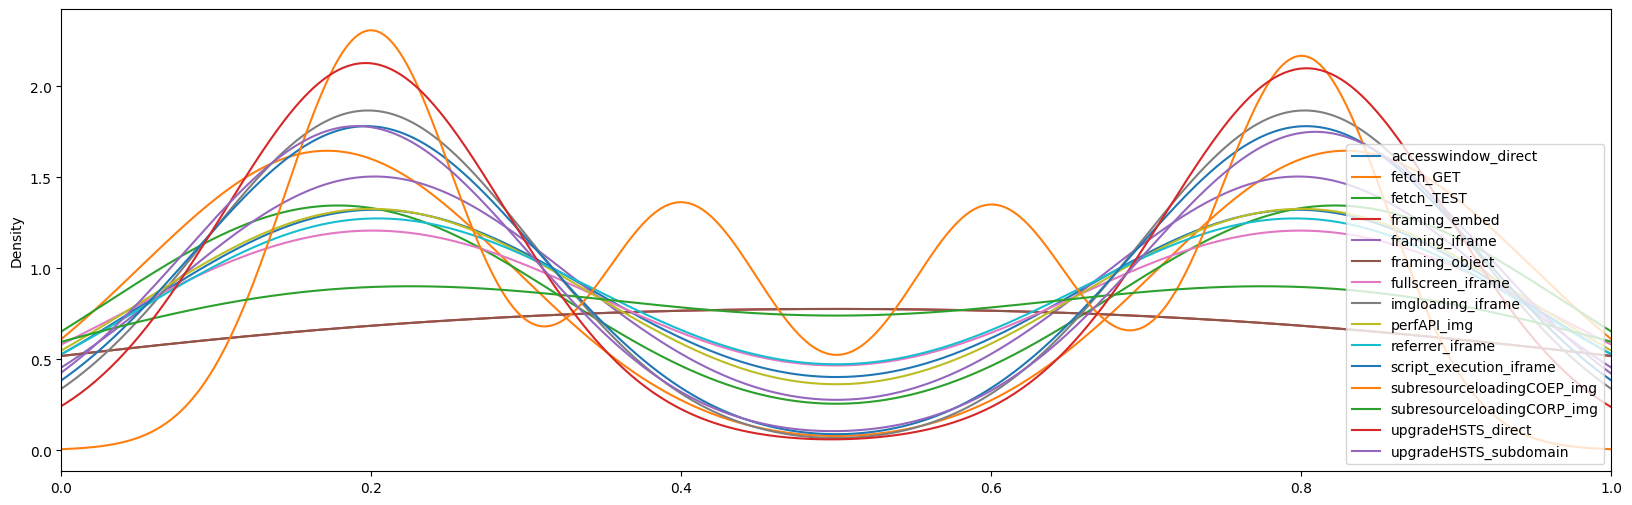

count
browser                                        test_name                        
firefox_beta Android 11 123.0b9 intent real    subresourceloadingCOEP_img     76
chrome iPadOS 17.3.1 122.0.6261.89 intent real subresourceloadingCOEP_img     72
safari macOS 14.3.1 17.3.1 selenium real       subresourceloadingCOEP_img     57
firefox Ubuntu 22.04 121 selenium headless     subresourceloadingCOEP_img     46
firefox Ubuntu 22.04 123 selenium headless     subresourceloadingCOEP_img     46
firefox Ubuntu 22.04 122 selenium headless     subresourceloadingCOEP_img     33
brave Android 11 1.62.165 intent real          upgradeHSTS_direct             16
                                               upgradeHSTS_subdomain           5
chrome Android 11 121.0.6167.180 intent real   upgradeHSTS_direct              3
brave Android 11 1.62.165 intent real          referrer_iframe                 2
chrome Android 11 121.0.6167.180 intent real   accesswindow_direct             1
brave Android 11 1.62.165 intent real          accesswindow_direct             1
chrome Ubuntu 22.04 121 selenium headless-new  framing_iframe                  1
chrome Android 11 121.0.6167.180 intent real   referrer_iframe                 1
safari macOS 14.3.1 17.3.1 selenium real       upgradeHSTS_direct              1
                                               upgradeHSTS_subdomain           1

proportion
0.200000    1149
0.800000    1111
0.400000     334
0.600000     333
0.833333      58
0.166667      58
0.142857      31
0.857143      31
0.100000      27
0.900000      27
0.111111      15
0.888889      14
0.125000      12
0.875000      12
0.750000       8
0.250000       8
0.666667       6
0.222222       6
0.333333       5
0.777778       5
0.300000       4
0.700000       4
0.285714       3
0.714286       3
0.785714       1
0.214286       1
0.357143       1
0.642857       1
0.625000       1
0.375000       1
Name: count, dtype: int64

In [695]:
# What is the ration of different outcomes for tests with more than one outcome?
test = df.groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])['outcome_str'].value_counts(normalize=True).reset_index()

# General information on tests with more than one outcome
mean_max_value = test.loc[test["proportion"] != 1.0].groupby(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "browser", "resp_type"])["proportion"].max().reset_index()
display(mean_max_value["proportion"].agg(["count", "mean", "std", "min", "median", "max"]))        
display(mean_max_value.groupby("test_name")["proportion"].agg(["count", "mean", "std", "min", "median", "max"]))

# Tests where the most common and second most commont outcome is close (majority vote only is between 0.5 and 0.79) -> noisy test, majority vote might be wrong?
display(test.loc[(test['proportion'] >= 0.5) & (test['proportion'] <= 0.79)]["test_name"].value_counts())

# As a density plot
ax = test.loc[test["proportion"] != 1.0].groupby("test_name")["proportion"].plot(kind="kde", xlim=(0, 1), legend=True, figsize=(20, 6))
ax.iloc[0].legend(loc='lower right')  # Customize the legend location
plt.show()

# Same grouped by browsers
display(test.loc[(test['proportion'] >= 0.5) & (test['proportion'] <= 0.79)].groupby("browser")["test_name"].value_counts().to_frame().sort_values(by="count", ascending=False))

# Raw value counts of proportions
with pd.option_context("display.max_rows", 77):
    display(test.loc[test["proportion"] != 1.0]["proportion"].value_counts())

### Majority Voting
- Perform majority voting
- Only firefox_beta Android 11 (basic) subresourceloadingCOEP_img has 8 tests with the same mode, we simply choose the first in such cases

In [696]:
df = df_org
df = df.loc[df["test_status"] == 0]

In [697]:
df_stab = df

# Only keep one row for each test
# If the test had non-deterministic results, use majority voting! (only works reliably if there a enough repetitions of the tests runs, >= 5)

print("Original data entries", len(df))

# Majority voting (pd.Series.mode returns the most frequest item) (quite slow)

df = df.groupby(["test_id", "browser"], observed=True)["outcome_str"].agg(pd.Series.mode).reset_index()
print("Only one row for each test (per browser; majority voting)", len(df))

Original data entries 10833923
Only one row for each test (per browser; majority voting) 2101920


In [698]:
# Merge back additional required properties!
# ["name", "test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "resp_type", "label", 'org_origin', 'resp_origin', 'status_code', 'raw_header']

df = df.merge(df_stab.drop_duplicates(subset=["test_id", "browser"]), on=["test_id", "browser"], how="left", suffixes=["", "_ignore"])


In [699]:
# Tests with same mode?! maybe rerun again?!
with pd.option_context("display.max_colwidth", None):
    # Firefox subresourceloadingCOEP_img
    # Ignore, indeterminisitc behavior.
    display(df.loc[(df["browser"] == 'firefox_beta Android 11 123.0b9 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    # Duckduckgo oac, RP, COOP
    # Rerun all three groups with higher timeouts?
    display(df.loc[(df["browser"] == 'duckduckgo Android 11 5.194.0 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    
    # Brave (Android) oac_window.open
    # Rerun one URL! -> fixed
    display(df.loc[(df["browser"] == 'brave Android 11 1.62.165 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

    # Opera (Android) ugrade_HSTS_direct
    # Rerun one URL! -> fixed
    display(df.loc[(df["browser"] == 'opera Android 11 80.5.4244.78163 intent real') & (df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray)))][["outcome_str", "full_url"]])

,outcome_str,full_url
1817350,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=58&last_id=58&scheme=http&run_id=645058ab2c9143599e445a365f502857
1817362,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=59&last_id=59&scheme=http&run_id=141f1711bc294e1db4f626281598088a
1817434,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=65&last_id=65&scheme=http&run_id=50b6106d332c437f8a76f52d34f6bbb6
1817710,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=66&last_id=66&scheme=http&run_id=db5f71465546446eacf64876591928e2
1817818,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=64&last_id=64&scheme=http&run_id=f0376075d30b402585774303b11dcda4
1817842,"[{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}]",http://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=66&last_id=66&scheme=http&run_id=db5f71465546446eacf64876591928e2
1850062,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}, {'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}]",https://sub.headers.websec.saarland/_hp/tests/subresource-loading-coep.sub.html?timeout=10&resp_type=basic&browser_id=64&label=COEP&first_id=59&last_id=59&scheme=https&run_id=c38e1479189245d8a7b5ec707d79f6a0
1850458,"[{'image-events': {'swag.jpg': 'error', 'swag-same-site.

,outcome_str,full_url


,outcome_str,full_url


,outcome_str,full_url


In [700]:
# If several values occur the same, the mode is an np.ndarray and not a string!
# If we have exactly 5 repetitions for each test, the issue cannot exist!
# However, our repeat system only enables us to have 5+ results for each test
print("Tests with the same mode (highest frequency outcome):")
display(df.loc[df['outcome_str'].apply(lambda x: isinstance(x, np.ndarray))].groupby(["browser", "resp_type", "test_name"])["outcome_str"].count())

# In the rare cases, where it actually matters, we can just take the first? (this might be noise in the generated trees and other summaries!)
# These are unstable tests that might indicate random behavior in the browser (e.g., firefox COEP_img)
df['outcome_str'] = df['outcome_str'].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

Tests with the same mode (highest frequency outcome):


browser                                      resp_type  test_name                 
firefox_beta Android 11 123.0b9 intent real  basic      subresourceloadingCOEP_img    8
Name: outcome_str, dtype: int64

# Browser differences
- Most tests have one outcome only (not interesting for us)
- 4346 tests have two outcomes, 60 tests have three outcomes
- All test rows: 2101920, should be: 2101920, Rows with more than one outcome: 52848, Tests with more than one outcome: 4404

In [701]:
# Most tests have exactly one outcome, quite some have two, couple have three!
res = df.groupby(["resp_type", "test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id", "test_id"], observed=True)
res = res["outcome_str"].agg("nunique")
display(res.value_counts().to_frame())

,count
outcome_str,
1,170756
2,4344
3,60


In [702]:
4406/(9784+165376)*100

2.515414478191368

## Differences per test group
- Basic:
    - subresourceloadingCORP_object 100% of test have different results (WebKit does not support postMessages on objects?)
    - couple of others have 20%+ differences
    - others have 0% 
- Parsing:
    - ~~oac_window.open has 99% (only supported in chromium)~~
    - other tests with differences are between 0.5% (fetch_GET) and 5% (upgradeHSTS_direct)

In [703]:
# Basic:
# subresourceloadingCORP_object has different results for 100% of tests
# couple of others have 20%+ differences
# couple have 0%

# Parsing:
# Test groups have between 0.5 - 5% of tests with different outcomes
# Highest: upgradeHSTS_direct with 4.69%
r = res.reset_index()
r["diff"] = r["outcome_str"] != 1
display(r.groupby(["resp_type", "test_name", "relation_info"])["diff"].agg(["count", "sum", "mean"]).sort_values("mean", ascending=False))
display(r.groupby(["resp_type", "test_name", "relation_info"])["diff"].agg(["mean"]).describe())
display(r.groupby(["test_name", "relation_info"])["diff"].agg(["mean"]).describe())

count  sum      mean
resp_type test_name                     relation_info                       
basic     subresourceloadingCORP_object direct            176  176  1.000000
          subresourceloadingCOEP_img    direct            176   88  0.500000
          referrer_iframe               window.open       256  120  0.468750
          fullscreen_iframe             direct            384  142  0.369792
          framing_embed                 direct            560  186  0.332143
          framing_object                direct            560  186  0.332143
          fullscreen_iframe             child_allow       384  113  0.294271
          perfAPI_img                   direct            208   55  0.264423
          framing_object                nested            560  120  0.214286
          framing_embed                 sandbox           560  120  0.214286
          framing_object                sandbox           560  120  0.214286
          framing_embed                 nested            560  120  0.214286
          accesswindow_direct           direct            176   28  0.159091
          script_execution_iframe       sandbox           272   21  0.077206
          referrer_iframe               iframe            256   18  0.070312
          fullscreen_iframe             child             384   23  0.059896
          imgloading_iframe             direct            272   13  0.047794
parsing   upgradeHSTS_direct            direct           6648  310  0.046631
          fullscreen_iframe             child_allow      7760  355  0.045747
          imgloading_iframe             direct           5420  230  0.042435
          script_execution_iframe       direct           5452  216  0.039618
basic     upgradeHSTS_direct            direct             28    1  0.035714
parsing   fullscreen_iframe             direct           7760  272  0.035052
basic     subresourceloadingCOEP_img    sandbox           176    4  0.022727
parsing   subresourceloadingCOEP_img    direct           5274  110  0.020857
          framing_iframe                direct          17560  365  0.020786
          referrer_iframe               iframe           5594  101  0.018055
          upgradeHSTS_subdomain         subdomain        6648  101  0.015193
basic     framing_iframe                sandbox           560    8  0.014286
parsing   perfAPI_img                   direct           3202   33  0.010306
          subresourceloadingCORP_img    direct           6714   68  0.010128
          accesswindow_direct           direct           5312   44  0.008283
          framing_iframe                nested          17560  144  0.008200
          fetch_GET                     simple          16118  104  0.006452
          fetch_TEST                    custom_method   16118  101  0.006266
          fetch_GET                     custom_headers  16118  101  0.006266
basic     subresourceloadingCORP_img    direct            176    1  0.005682
parsing   fetch_GET                     credentials     16118   86  0.005336
basic     fetch_TEST                    custom_method      96    0  0.000000
          framing_iframe                direct            560    0  0.000000
          fetch_GET                     simple             96    0  0.000000
          fullscreen_iframe             child_sandbox     384    0  0.000000
          framing_iframe                nested            560    0  0.000000
          fetch_GET                     custom_headers     96    0  0.000000
                                        credentials        96    0  0.000000
          upgradeHSTS_subdomain         subdomain          28    0  0.000000
          subresourceloadingCORP_img    sandbox           176    0  0.000000
                                        nested            176    0  0.000000
          script_execution_iframe       direct            272    0  0.000000

,mean
count,49.000000
mean,0.107285
std,0.185865
min,0.000000
25%,0.005682
50%,0.020857
75%,0.159091
max,1.000000


,mean
count,32.000000
mean,0.111644
std,0.200826
min,0.000000
25%,0.009498
50%,0.031068
75%,0.111476
max,1.000000


In [704]:
# Select only test rows with more than one outcome
tests_with_mult_outcomes = r.loc[r["diff"]].set_index(["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"])
df_mult = df.loc[df[["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"]].apply(tuple, axis=1).isin(tests_with_mult_outcomes.index)]
tests_with_more_than_one_outcome = df_mult.drop_duplicates(subset=["test_name", "org_scheme", "org_host", "resp_scheme", "resp_host", "relation_info", "response_id"])


all_tests_should_be =  df_org.loc[df_org["test_status"] == 0]["test_id"].nunique() * df_org["browser"].nunique() # (num parsing tests + num_basic_tests) * num_browsers (168774+10456)
print(f"All test rows: {len(df)}, should be: {all_tests_should_be}, Rows with more than one outcome: {len(df_mult)}, Tests with more than one outcome: {len(tests_with_more_than_one_outcome)}")

All test rows: 2101920, should be: 2101920, Rows with more than one outcome: 52848, Tests with more than one outcome: 4404


## Browser similarity
- Matrix for differences between all browsers split by all results, only parsing, only basic, only specific test types
- In general:
    - Chromium != Firefox != WebKit
    - Brave is different to Chrome (whereas Opera, Edge are equal to Chrome?)
    - Firefox and WebKit are close together
    - Differences between Mobile and Desktop exist but are small (for all brave, chrome, firefox, safari)

In [705]:
df["b_short"] = df["os"].apply(lambda x: x.split(" ")[0]) + " " + df["name"] + "(" + df["version"] + ")"

In [706]:
# Simmilarity between browsers and versions!

# Function to calculate absolute and percentage overlap
def calculate_overlap(df, col1, col2):
    df = df[[col1, col2]].dropna()
    df.columns.values[0] = 0
    df.columns.values[1] = 1
    absolute_overlap = (df[0] == df[1]).sum()
    unique_rows = len(df)
    diff_rows = unique_rows - absolute_overlap
    percentage_diff = (diff_rows / unique_rows) * 100
    return diff_rows, percentage_diff, unique_rows

def rename_rows(df):
    for row_index in df.index:
        for column_name in df.columns:
            if row_index.startswith(column_name.split(',')[0]):
                df.rename(index={row_index: column_name}, inplace=True)
                break  # Stop searching for matching column names once found
    return df


def display_overlap(df, show_all=True, name="All"):
    print(name)
    sim_frame = df.set_index(["test_id", "b_short"])["outcome_str"].unstack().astype("str")
    sim_frame = sim_frame.reset_index().drop(columns=["test_id"])
    # Create a dictionary to store results
    results = {}
    matrix = {}
    
    # Iterate through all pairs of columns
    for i, col1 in enumerate(sim_frame.columns):
        for col2 in sim_frame.columns:
            key = f"{col1}_vs_{col2}"
            results[key] = calculate_overlap(sim_frame, col1, col2)
            try:
                l = matrix[col1]
            except KeyError:
                l = {}
            # 0 for absolute count of differences, 1 for percentage
            l[col2] = results[key][0]
            matrix[col1] = l
            
    # Convert the results to a DataFrame for better visualization
    results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Absolute Diff', 'Percentage Diff', "Count"])

    s = {}
    for key, value in matrix.items():
        value_tuple = tuple(value.items())
        try:
            s[value_tuple].append(key)
        except KeyError:
            s[value_tuple] = [key]
    s_swapped = {", ".join(value): dict(key) for key, value in s.items()}
    # Display difference matrix
    with pd.option_context("display.max_columns", 28):
        final_frame = pd.DataFrame(s_swapped).drop_duplicates()
        final_frame = rename_rows(final_frame)
        display(final_frame)
        return final_frame

In [707]:
display_overlap(df)

for name, group in df.groupby("resp_type"):
    display_overlap(group, show_all=True, name=name)

for name, group in df.groupby("test_name"):
    display_overlap(group, show_all=False, name=name)

All


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,68,3121,138,87,88,3113,3110,3108,2772,2803
Android chrome(121.0.6167.180),68,0,3089,161,20,21,3081,3078,3076,2753,2784
Android firefox_beta(123.0b9),3121,3089,0,3080,3107,3108,90,83,87,2808,2757
Ubuntu brave(v1.62.156 (121.0.6167.139)),138,161,3080,0,141,142,3046,3043,3041,2718,2757
Ubuntu chrome(120),87,20,3107,141,0,1,3073,3070,3068,2759,2798
"Ubuntu chrome(121), Ubuntu chrome(122)",88,21,3108,142,1,0,3074,3071,3069,2760,2799
Ubuntu firefox(121),3113,3081,90,3046,3073,3074,0,27,33,2784,2725
Ubuntu firefox(122),3110,3078,83,3043,3070,3071,27,0,38,2781,2728
Ubuntu firefox(123),3108,3076,87,3041,3068,3069,33,38,0,2777,2710
iPadOS chrome(122.0.6261.89),2772,2753,2808,2718,2759,2760,2784,2781,2777,0,103


basic


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,63,580,50,69,70,556,556,557,1486,1539
Android chrome(121.0.6167.180),63,0,551,77,6,7,527,527,528,1471,1524
Android firefox_beta(123.0b9),580,551,0,599,557,558,54,54,51,1204,1155
Ubuntu brave(v1.62.156 (121.0.6167.139)),50,77,599,0,71,72,575,575,576,1506,1559
Ubuntu chrome(120),69,6,557,71,0,1,533,533,534,1477,1530
"Ubuntu chrome(121), Ubuntu chrome(122)",70,7,558,72,1,0,534,534,535,1478,1531
Ubuntu firefox(121),556,527,54,575,533,534,0,12,15,1166,1117
Ubuntu firefox(122),556,527,54,575,533,534,12,0,15,1166,1117
Ubuntu firefox(123),557,528,51,576,534,535,15,15,0,1167,1118
iPadOS chrome(122.0.6261.89),1486,1471,1204,1506,1477,1478,1166,1166,1167,0,53


parsing


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),"Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,5,2541,88,18,2557,2554,2551,1286,1264
Android chrome(121.0.6167.180),5,0,2538,84,14,2554,2551,2548,1282,1260
Android firefox_beta(123.0b9),2541,2538,0,2481,2550,36,29,36,1604,1602
Ubuntu brave(v1.62.156 (121.0.6167.139)),88,84,2481,0,70,2471,2468,2465,1212,1198
"Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",18,14,2550,70,0,2540,2537,2534,1282,1268
Ubuntu firefox(121),2557,2554,36,2471,2540,0,15,18,1618,1608
Ubuntu firefox(122),2554,2551,29,2468,2537,15,0,23,1615,1611
Ubuntu firefox(123),2551,2548,36,2465,2534,18,23,0,1610,1592
iPadOS chrome(122.0.6261.89),1286,1282,1604,1212,1282,1618,1615,1610,0,50
macOS safari(17.3.1),1264,1260,1602,1198,1268,1608,1611,1592,50,0


accesswindow_direct


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,4,53,15,63,33,25
Android chrome(121.0.6167.180),4,0,57,11,67,37,29
Android firefox_beta(123.0b9),53,57,0,68,12,36,28
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",15,11,68,0,56,40,40
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",63,67,12,56,0,40,40
iPadOS chrome(122.0.6261.89),33,37,36,40,40,0,8
macOS safari(17.3.1),25,29,28,40,40,8,0


fetch_GET


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,291,94
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",291,0,197
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",94,197,0


fetch_TEST


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,101,55
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",101,0,46
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",55,46,0


framing_embed


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",426,0


framing_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,517,95
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",517,0,422
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",95,422,0


framing_object


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",426,0


fullscreen_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,905,900
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",905,0,9
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",900,9,0


imgloading_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,243,41
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",243,0,202
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",41,202,0


perfAPI_img


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,66,22,74
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",66,0,88,40
iPadOS chrome(122.0.6261.89),22,88,0,52
macOS safari(17.3.1),74,40,52,0


referrer_iframe


,Android brave(1.62.165),Android chrome(121.0.6167.180),"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,59,207,116,65,66,189
Android chrome(121.0.6167.180),59,0,174,147,6,7,170
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",207,174,0,153,180,181,26
Ubuntu brave(v1.62.156 (121.0.6167.139)),116,147,153,0,141,142,135
Ubuntu chrome(120),65,6,180,141,0,1,176
"Ubuntu chrome(121), Ubuntu chrome(122)",66,7,181,142,1,0,177
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",189,170,26,135,176,177,0


script_execution_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,216,43
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",216,0,215
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",43,215,0


subresourceloadingCOEP_img


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,117,97,94,92,91,77
Android firefox_beta(123.0b9),117,0,76,69,73,130,136
Ubuntu firefox(121),97,76,0,27,33,104,94
Ubuntu firefox(122),94,69,27,0,38,101,97
Ubuntu firefox(123),92,73,33,38,0,97,79
iPadOS chrome(122.0.6261.89),91,130,104,101,97,0,42
macOS safari(17.3.1),77,136,94,97,79,42,0


subresourceloadingCORP_img


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,57,36,37
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",57,0,45,44
iPadOS chrome(122.0.6261.89),36,45,0,1
macOS safari(17.3.1),37,44,1,0


subresourceloadingCORP_object


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,32,176
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",32,0,176
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",176,176,0


upgradeHSTS_direct


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,5,248,7,250,91
Android chrome(121.0.6167.180),5,0,245,3,247,87
Android firefox_beta(123.0b9),248,245,0,246,2,284
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",7,3,246,0,244,84
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",250,247,2,244,0,282
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",91,87,284,84,282,0


upgradeHSTS_subdomain


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,68,54
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",68,0,80
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",54,80,0


## Decision trees
- Create decisison trees for all test rows that have different outcomes (not too helpful?!)
- For manual analysis

In [870]:
# Limit on responses that have more than one outcome!
# This will remove all the branches that are the same in all browsers (and make trees large and confusing)
condition = df.groupby(["test_id"], observed=True)["outcome_str"].transform("nunique") != 1
tree_df = df.loc[condition]
print("Remove tests that are the same in all browsers. Remaining rows:", len(tree_df))

Remove tests that are the same in all browsers. Remaining rows: 52848


In [871]:
# How many rows exist for tree creation
with pd.option_context("display.max_rows", 100):
    display(tree_df[["test_name", "label", "relation_info"]].value_counts())

test_name                      label       relation_info 
fullscreen_iframe              PP          child_allow       5616
                                           direct            4968
upgradeHSTS_direct             HSTS        direct            3732
imgloading_iframe              CSP-IMG     direct            2916
framing_iframe                 CSP-FA      direct            2628
script_execution_iframe        CSP-SCRIPT  direct            2592
subresourceloadingCOEP_img     COEP        direct            2376
subresourceloadingCORP_object  CORP        direct            2112
referrer_iframe                RP          window.open       1440
                                           iframe            1428
framing_iframe                 CSP-FA      nested            1284
framing_embed                  CSP-FA      direct            1224
framing_object                 CSP-FA      direct            1224
upgradeHSTS_subdomain          HSTS        subdomain         1212
perfAPI_img       

In [333]:
h2o.init(nthreads=50, max_mem_size="100G", log_level="WARN")
h2o.no_progress()

base_dir = f"trees/{datetime.today().strftime('%Y-%m-%dT%H:%M')}" 

for group_name, group in tree_df.groupby(["test_name", "relation_info"]):
    print(group_name)
    pred_cols = ["browser", "org_origin", "resp_origin", "status_code", "raw_header"]
    group = group[["outcome_str", *pred_cols]]
    tree = make_tree(group, pred_cols, group_name, base_dir)
    # print(tree)


Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


('accesswindow_direct', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('accesswindow_direct', 'direct'), datapoints: 1008
('fetch_GET', 'credentials')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_GET', 'credentials'), datapoints: 1204
('fetch_GET', 'custom_headers')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_GET', 'custom_headers'), datapoints: 1414
('fetch_GET', 'simple')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_GET', 'simple'), datapoints: 1456
('fetch_TEST', 'custom_method')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fetch_TEST', 'custom_method'), datapoints: 1414
('framing_embed', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_embed', 'direct'), datapoints: 2604
('framing_embed', 'nested')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_embed', 'nested'), datapoints: 1680
('framing_embed', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_embed', 'sandbox'), datapoints: 1680
('framing_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_iframe', 'direct'), datapoints: 5110
('framing_iframe', 'nested')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_iframe', 'nested'), datapoints: 2016
('framing_iframe', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_iframe', 'sandbox'), datapoints: 112
('framing_object', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_object', 'direct'), datapoints: 2604
('framing_object', 'nested')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_object', 'nested'), datapoints: 1680
('framing_object', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('framing_object', 'sandbox'), datapoints: 1680
('fullscreen_iframe', 'child')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fullscreen_iframe', 'child'), datapoints: 322
('fullscreen_iframe', 'child_allow')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fullscreen_iframe', 'child_allow'), datapoints: 6552
('fullscreen_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('fullscreen_iframe', 'direct'), datapoints: 5796
('imgloading_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('imgloading_iframe', 'direct'), datapoints: 3402
('perfAPI_img', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('perfAPI_img', 'direct'), datapoints: 1232
('referrer_iframe', 'iframe')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('referrer_iframe', 'iframe'), datapoints: 1666
('referrer_iframe', 'window.open')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('referrer_iframe', 'window.open'), datapoints: 1680
('script_execution_iframe', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('script_execution_iframe', 'direct'), datapoints: 3024
('script_execution_iframe', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('script_execution_iframe', 'sandbox'), datapoints: 294
('subresourceloadingCOEP_img', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 9 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCOEP_img', 'direct'), datapoints: 2772
('subresourceloadingCOEP_img', 'sandbox')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCOEP_img', 'sandbox'), datapoints: 56
('subresourceloadingCORP_img', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.6 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCORP_img', 'direct'), datapoints: 966
('subresourceloadingCORP_object', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.5 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('subresourceloadingCORP_object', 'direct'), datapoints: 2464
('upgradeHSTS_direct', 'direct')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.5 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('upgradeHSTS_direct', 'direct'), datapoints: 4382
('upgradeHSTS_subdomain', 'subdomain')
Connecting to H2O server at http://localhost:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,43 days 2 hours 10 mins
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.2
H2O_cluster_version_age:,4 months and 28 days
H2O_cluster_name:,H2O_from_python_ubuntu_u7y7iq
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,99.5 Gb
H2O_cluster_total_cores:,160
H2O_cluster_allowed_cores:,50
H2O_cluster_status:,"locked, healthy"


Create tree: ('upgradeHSTS_subdomain', 'subdomain'), datapoints: 1414


# Manual analysis
- Noise check/Manual confirmation:
    - Android: http://134.96.225.54:8888/#!/control/emulator-5554

## Helpers

In [872]:
# Open Tree SVG
from IPython.display import display, HTML
import os

def open_tree(tree_name):
    directory = 'trees/'
    latest_tree_directory = max([os.path.join(directory, d) for d in os.listdir(directory)], key=os.path.getmtime)
    file_path = f"http://localhost:8888/files/analysis/{latest_tree_directory}/svg/{tree_name}.svg"
    html_link = f'<a href="{file_path}" target="_blank">Open {tree_name}.svg</a>'
    display(HTML(html_link))

open_tree("('accesswindow_direct', 'direct')")

In [873]:
def show_overlap(test_name, groupby=True, show_all=True):
    d = df.loc[df["test_name"] == test_name]
    if groupby:
        for name, group in d.groupby("resp_type"):
            display_overlap(group, show_all=show_all, name=name)
    else:
        display_overlap(d, show_all=show_all, name="all")


In [874]:
from io import StringIO
import ipywidgets as widgets
from utils import clickable
from functools import partial

class DataFrameWidget(widgets.VBox):
    def __init__(self, df, rows_per_page=20):
        self.df = df
        self.rows_per_page = rows_per_page
        self.page_index = 0
        self.total_pages = (len(df) - 1) // rows_per_page + 1
        
        self.output = widgets.Output()
        
        self.prev_button = widgets.Button(description='Prev')
        self.prev_button.on_click(self.prev_page)
        self.next_button = widgets.Button(description='Next')
        self.next_button.on_click(self.next_page)
        
        self.page_label = widgets.Label(value=f'Page: {self.page_index + 1} / {self.total_pages}')
        
        self.update_output()

        super().__init__(children=[self.output, 
                                   widgets.HBox([self.prev_button, self.next_button]),
                                   self.page_label])
    
    def update_output(self):
        start = self.page_index * self.rows_per_page
        end = min((self.page_index + 1) * self.rows_per_page, len(self.df))
        display_df = self.df.iloc[start:end]
        
        with self.output:
            self.output.clear_output()
            with pd.option_context("display.max_colwidth", 500):
                click_func = partial(clickable, "URL")
                display_df = display_df.style.format({'url': click_func})
                display(display_df)
        self.page_label.value = f'Page: {self.page_index + 1} / {self.total_pages}'
    
    def prev_page(self, _):
        if self.page_index > 0:
            self.page_index -= 1
            self.update_output()
    
    def next_page(self, _):
        if self.page_index < self.total_pages - 1:
            self.page_index += 1
            self.update_output()


def show_response_groups(test_name, relation=None):
    splits = {}
    d = tree_df.loc[tree_df["test_name"] == test_name]
    if relation:
        d = d.loc[d["relation_info"] == relation]
    for test_id, group in d.groupby("test_id", observed=True):
        key = group[["browser", "outcome_str"]].drop_duplicates().sort_values("browser")
        key = key.to_csv(index=False)
        try:
            splits[key].append(test_id)
        except (AttributeError, KeyError):
            splits[key] = [test_id]

    tab_contents = []
    
    for i, (key, values) in enumerate(splits.items()):        
        # Prepare content for the tab
        main_output = widgets.Output()
        with main_output:
            print(f"Group {i}")
            display(pd.read_csv(StringIO(key)).groupby("outcome_str")["browser"].unique().apply(sorted).to_dict())
            with pd.option_context("display.max_colwidth", 500):
                cur_data = tree_df.loc[tree_df["test_id"].isin(values)]
                example = cur_data.iloc[0]
                example_url = example["clean_url"]
                example_element_relation = example["test_name"].split("_")[1] + "_" + example["relation_info"]
                example_resp_origin = example["resp_origin"]
                example_resp_id = example["response_id"]
                example_url += f"&t_resp_id={example_resp_id}&t_element_relation={example_element_relation}&t_resp_origin={example_resp_origin}"
                display(example_url)
                
                d_data = cur_data.drop_duplicates(subset=["raw_header", "status_code", "org_origin", "resp_origin", "response_id"]).sort_values(by=["raw_header", "status_code", "org_origin", "resp_origin"])
                d_data["url"] = d_data["clean_url"] + "&t_resp_id=" + d_data["response_id"].astype(str) + "&t_element_relation=" + d_data["test_name"].apply(lambda x: x.split("_")[1]) + "_" + d_data["relation_info"] + "&t_resp_origin=" + d_data["resp_origin"]
                d_data = d_data[["raw_header", "status_code", "org_origin", "resp_origin", "response_id", "url"]]

                # Display the DataFrame
                display(DataFrameWidget(d_data))
        
        # Add the content to the tab
        tab_contents.append(main_output)
    
    # Create tabs
    tab = widgets.Tab()
    tab.children = tab_contents

    
    # Set tab titles
    for i in range(len(tab_contents)):
        tab.set_title(i, f"Group {i}")
    
    display(tab)
                
            

In [875]:
def show_outcome_nums(test_name):
    display(pd.concat([df.loc[df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique"), tree_df.loc[tree_df["test_name"] == test_name].pivot_table("test_id", "outcome_str", aggfunc="nunique")], axis=1))

def show_response_nums(test_name):
    display(tree_df.loc[tree_df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().apply(len))
    display(df.loc[df["test_name"] == test_name].groupby("resp_type")["raw_header"].unique().apply(len))

## accesswindow_direct/COOP window-references-coop.sub.html
- Testfile: `window-references-coop.sub.html`
- Testnames: accesswindow_direct
- Header: COOP
- Basic:
    - Android chrome (121), Ubuntu chrome (120-122), edge (121), brave (121) are identical
    - Android: Opera + brave sligthly different?
    - Safari, Firefox (all platforms) are identical
    - The two groups have 28 differences
- Parsing:
    - Ubuntu chrome (120-122), edge (121), brave (121), opera (Android 121) are identical
    - Android: Brave + chrome identical
    - Firefox desktop identical
    - Safari almost identical to Chrome/Brave Android?
    - ...
- **Small amount of noise: mostly opera android**
- **Everything entered into google sheets**

In [876]:
test_name = 'accesswindow_direct'

In [877]:
# Tree
open_tree(f"('{test_name}', 'direct')")

In [878]:
show_overlap(test_name, groupby=True, show_all=True)

basic


,Android brave(1.62.165),"Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,4,24
"Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",4,0,28
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",24,28,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180)",Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180)",0,29,11,39,9,1
Android firefox_beta(123.0b9),29,0,40,12,36,28
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",11,40,0,28,12,12
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",39,12,28,0,40,40
iPadOS chrome(122.0.6261.89),9,36,12,40,0,8
macOS safari(17.3.1),1,28,12,40,8,0


In [879]:
# Noise check/Manual confirmation:
# Android: http://134.96.225.54:8888/#!/control/emulator-5554


# Noise vs edge-case confirmation ?!
# Group 0 opera is in wrong group (noise)

# Group 5: confirmed 204 is handled differently on iPad

# Group 6: confirmed iPad is in the other group; not sure why? probably COOP applies before the download? (the difference between 2 is that \n is at the end, and the difference to 9 is that the COOP value is blocking)

# Group 7 opera is also in the firefox group (recorded result was noisy?)
# Group 8 opera + brave stay the same/no noise; actual difference might be: only chrome applies redirect + COOP!
# Difference between (0,1) and (7,8) is that the latter uses http://sub.headers.websec.saarland; seems like opera + brave do not auto-update this origin (exception?)


# Final Groups:
# 0+1 COOP only active on HTTPS, even though resp_origin is HTTP COOP is active in chromium-based browsers due to HTTPS auto-upgrade; (opera had noise once thus 2 groups)
# 2,9 Varying download behavior: download triggered due to \n in response. Safari (+ Android without Opera?) download pages are treated similarily to about:blank? (brave + chrome had noise once thus 2 groups)
# 3 \r, \t, or space at the beginning or end of header name allowed in all non-firefox browsers;
# 4 1. Two headers, one empty: COOP active in Firefox, not-active in other browsers (which behavior is correct?), 2. \r at the end of the header name: works in Firefox, does not work in the other browsers!
# 5 Status code 204 + COOP works on iPad; does not work in other browsers (bug?)
# 6 similar to 2, only difference iPad in other group; (\n at the end!)
# 7,8 Similar to 0+1, however opera + brave (Android) do not auto update to https here (exception?) (opera had noise once thus 2 groups)

show_response_groups(test_name)

## Fetch/CORS 
- Testfile: `fetch-cors.sub.html`
- Testnames: `fetch_GET_credentials|custom_headers_simple, fetch_TEST_custom_method`
- Headers: ACAO, ACAM, ACAH, ACAC, ACEH
- Basic + Parsing, ...
- **No noise** (anymore)

In [880]:
test_name = 'fetch_GET' # fetch_TEST

In [881]:
# Trees
open_tree("('fetch_GET', 'credentials')")
open_tree("('fetch_GET', 'custom_headers')")
open_tree("('fetch_GET', 'simple')")
open_tree("('fetch_TEST', 'custom_method')")

In [882]:
show_overlap(test_name, groupby=True, show_all=True)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,291,94
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",291,0,197
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",94,197,0


In [883]:
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

,test_id,test_id
outcome_str,,
"{'error': 'null', 'headers': ''}",3,3.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-headers,access-control-allow-methods,access-control-allow-origin,access-control-expose-headers,content-length,date,location,server,test,'}",1,1.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-headers,access-control-allow-methods,access-control-allow-origin,access-control-expose-headers,content-length,date,server,test,'}",91,12.0
"{'error': 'null', 'headers': 'access-control-allow-credentials,access-control-allow-origin,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-credentials,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-origin,cache-control,content-type,date,server,'}",6,NaN
"{'error': 'null', 'headers': 'access-control-allow-origin,content-length,date,server,test,'}",6,NaN
"{'error': 'null', 'headers': 'cache-control,content-type,'}",35,10.0
"{'error': 'null', 'headers': 'content-length,'}",4516,49.0


resp_type
parsing    96
Name: raw_header, dtype: int64

resp_type
basic         6
parsing    7969
Name: raw_header, dtype: int64

In [884]:
# Simple
# 0: 2 differences, Firefox vs All: 1. Firefox allows \r at the end of headers 2. Firefox allows two acao header with '' and with '*'
# 1: Firefox vs All: Firefox times out if \n in a response to fetch
# 2: Firefox vs all: Firefox fails fetch if either starts with \r or ends with space or \t
# 3: Firefox vs all: Only Firefox redirects for status code 300
# 4: Firefox vs all: similar to 1, firefox times out if \n in a response
# 5: Chromium-based vs others: \x00 (header-name) not allowed in Chromium
# 6: Firefox vs all: similar to 3
# 7: similar to 5
# 8: Firefox vs all: Only Firefox allows \r at end of header or at the start of the value
# 9: similar to 2
# 10: similar to 8
# 11: similar to 3
show_response_groups(test_name, relation="simple")

In [885]:
# credentials
# 0: Firefox vs all: \n timeout
# 1: Only firefox allows double acac + \r at the end of headers
# 2: Firefox does not allow \r at the beginning of headers or \t and space at the end + redirect 300
# 3: Chromium does not allow \x00 (header names)
# 4: same as 3
# 5: same as 2
# 6: Firefox vs all: Only Firefox allows \r at end of header or at the start of the value
# 7: only firefox redirects for 300
show_response_groups(test_name, relation="credentials")

In [886]:
# custom_headers
# 0: Only firefox allows \r and double header
# 1: Firefox + WebKit abort if \n in response?
# 2: Firefox \r, \t and space (\r special case if in other unrelated header e.g., ACAM)
# 3: \x00 in header names
# 4: same as 2
# 5: \x00 in header names
# 6: same as 0
# 7: same as 2
# 8: same as 0
show_response_groups(test_name, relation="custom_headers")

In [887]:
# custom_method
# 0: Firefox \r + double header
# 1: \n in response Firefox + WebKit do not like
# 2: Firefox \r, \t, space (special \r in unrelated headers ignored by other browsers, Firefox errors)
# 3: \x00 in header names
# 4: Firefox \r, \t, space
# 5: \x00 in header names
# 6: Firefox \r in value + end of header
# 7: Firefox \r, \t, space
# 8: Firefox \r in value + end of header
show_response_groups("fetch_TEST", relation="custom_method")

## Framing
- Testfile: `framing.sub.html`
- Testnames: `framing_embed`, `framing_iframe`, `framing_object` all `direct`, `nested`, and `sandbox`
- Headers: XFO, CSP, XFOvsCSP
- Mostly Firefox vs the others, sometimes Safari agrees with Firefox and not with Chromium
- **No noise**
- **Everything entered into google sheets!**

In [888]:
test_name = 'framing_iframe' # framing_embed, framing_object (direct, nested, sandbox)

In [889]:
# Trees
open_tree("('framing_iframe', 'direct')")
open_tree("('framing_iframe', 'nested')")
open_tree("('framing_iframe', 'sandbox')")
open_tree("('framing_embed', 'direct')")
open_tree("('framing_embed', 'nested')")
open_tree("('framing_embed', 'sandbox')")
open_tree("('framing_object', 'direct')")
open_tree("('framing_object', 'nested')")
open_tree("('framing_object', 'sandbox')")

In [890]:
show_overlap(test_name, groupby=True, show_all=True)

show_outcome_nums(test_name)

# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",0,8
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",8,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,509,95
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",509,0,414
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",95,414,0


,test_id,test_id
outcome_str,,
message send,21769,517
message timeout,15548,517


resp_type
basic        1
parsing    222
Name: raw_header, dtype: int64

resp_type
basic        32
parsing    8726
Name: raw_header, dtype: int64

In [891]:
# 0: Firefox+Safari vs Chromium-based (2 issues): 1. uppercase scheme not allowed in chrome (bug), 2. \x00 not allowed in chrome (unclear?)
# 1: Firefox vs the others (only firefox allows): 
# - 1. Firefox ignores path for FA, Others do not even allow the correct path? (What is the correct behavior according to the specs?)
# - 2. Firefox does not allow \r at the beginning of a header name
# - 3. Firefox does not allow space and \t between header name and colon
# - 4. Firefox does not allow \x0b (vertical tab) at the beginning or end of header value
# 2: Firefox vs the others (only firefox disallows):
# - 1. Firefox allows \r at the beginning of header values
# - 2. Only Firefox redirects for status code 300
# - 3. \x0b (vertical tab) not ignored in Firefox, thus *\x0b != *
# - 4. Only Firefox allows \r at the end of a header name
# - 5. XFO: firefox allows space, \r, \t, \x0c (form feed) anywhere!
# - 6. \x01 - \x08, \x0e, \x0f, \x10 - \x1f, \x7f after * -> *\xNN -> blocked, after 'none'\xNN -> blocked (other browsers declare the full directive as invalid -> allowed?)
# 3: Firefox + Safari vs Chromium based: */ -> blocked in Firefox/Safari, allowed in Chromium?

# Old DuckDuckGo:
# 0: Duckduckgo (Webview 83) does not support various frame-ancestor value misspellings (empty, NoNe, \t, ...)
# 4: Firefox + duckduckgo(Webview 83): \x01 - \x08, \x0e, \x0f, \x10 - \x1f, \x7f after * -> *\xNN -> blocked, after 'none'\xNN -> blocked (other browsers declare the full directive as invalid -> allowed?)
# 5: Duckduckgo (Webview 83): \xa0a, ´, “, ... leads to response being blocked
show_response_groups(test_name, relation="direct")

In [892]:
# Nested
# More or less identical to `direct`? Some differences due to the fact that it is nested and the chain does not fullfill everything
show_response_groups(test_name, relation="nested")

In [893]:
# Sandbox
# 0: Firefox vs the rest: `frame-ancestors *` matches sandboxed frame, does not match in the other browsers (compare https://www.w3.org/TR/CSP3/#match-url-to-source-expression)
# Error message in Chrome is wrong/misleading (Safari as well). However behavior is correct, `sandbox` without `allow-same-origin` is an opaque origin that should not be matched by *

# Old duckduckgo:
# 0: Duckduckgo vs the rest: 1. mixed content blocking not working correctly?, 2. frame-ancestors without a value not working
show_response_groups(test_name, relation="sandbox")

In [894]:
# Embed direct
# 0: WebKit does not allow embeds/postMessages for embeds

# Old Duckduckgo:
# 1: Duckduckgo allows `CSP: frame-ancestors`
show_response_groups("framing_embed", relation="direct")

In [895]:
# Embed nested
# Same as embed direct?
show_response_groups("framing_embed", relation="nested")

In [896]:
# Embed sandbox
# Same as embed nested
show_response_groups("framing_embed", relation="sandbox")

In [897]:
# Object direct
# Same as embed direct (Safari does not allow postMessages on objects?)
show_response_groups("framing_object", relation="direct")

In [898]:
# Object nested
# Same as embed nested
show_response_groups("framing_object", relation="nested")

In [899]:
# Object sandbox
# Same as embed sandbox
show_response_groups("framing_object", relation="sandbox")

## Fullscreen/PP
- Testfile: `fullscreen-api-pp.sub.hml`
- Testnames: `fullscreen_iframe` with `direct`, `child`, `child_allow`, `child_sandbox`
- Headers: PP/FP
- Mostly Firefox/Safari vs Chromium, however also a small difference between Firefox and Safari
- **Everything entered into google sheets!** (nothing new: known FP and PP not supported yet in WebKit/Firefox, general parsing issues \x00, 300; we also found to old FP bugs in duckduckgo, however they were long discovered and fixed, still good to know? )
- **No noise**

In [900]:
test_name = 'fullscreen_iframe' 

In [901]:
# Trees
open_tree("('fullscreen_iframe', 'direct')")
open_tree("('fullscreen_iframe', 'child')")
open_tree("('fullscreen_iframe', 'child_allow')")
open_tree("('fullscreen_iframe', 'child_sandbox')")

In [902]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,278
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",278,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,627,622
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",627,0,9
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",622,9,0


,test_id,test_id
outcome_str,,
fullscreenEnabled: false,1181,873
fullscreenEnabled: true,12061,905
message timeout,4723,36


resp_type
basic       15
parsing    341
Name: raw_header, dtype: int64

resp_type
basic        24
parsing    3853
Name: raw_header, dtype: int64

In [903]:
with pd.option_context("display.max_rows", 154):
    display(df.loc[(df["test_name"] == test_name)].groupby(["relation_info", "browser"])["outcome_str"].value_counts())

relation_info  browser                                                              outcome_str             
child          brave Android 11 1.62.165 intent real                                message timeout              208
                                                                                    fullscreenEnabled: false     155
                                                                                    fullscreenEnabled: true       21
               brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  message timeout              208
                                                                                    fullscreenEnabled: false     155
                                                                                    fullscreenEnabled: true       21
               chrome Android 11 121.0.6167.180 intent real                         message timeout              208
                                                                        

In [904]:
df.loc[(df["test_name"] == test_name) & (df["outcome_str"] == "fullscreenEnabled: false")].groupby("browser")["relation_info"].value_counts()

browser                                                              relation_info
brave Android 11 1.62.165 intent real                                child_allow      458
                                                                     direct           392
                                                                     child_sandbox    176
                                                                     child            155
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new  child_allow      458
                                                                     direct           392
                                                                     child_sandbox    176
                                                                     child            155
chrome Android 11 121.0.6167.180 intent real                         child_allow      458
                                                                     direct           392
                 

In [905]:
# Direct
# 0: Permission Policy only supported in Chromium 88+, currently not supported in Safari/WebKit and Firefox, Feature Policy only supported in Chromium 60?+, Safari/WebKit only support the allow attribute?
# 1: \x00 breaks Chromium, response not rendered -> no message send
# 2/3: Status code 300 only redirects in Firefox
show_response_groups(test_name, relation="direct")

In [906]:
# Child
# Without the allow attribute only frames from the same origin should be allowed?
# 0: Only Chromium 88+ supports PP header (header blocks same-origin child), Only Chromium 60?+ supports FP header (header blocks same-origin child)

# Old duckduckgo:
# 0: Duckduckgo allows non-same origin responses without the allow tag if FP header allows it?
show_response_groups(test_name, relation="child")

In [907]:
# Child allow
# 0: Only chromium supports FP + PP header, Only chromium supports FP header
# 1: \x00 issue in chrome
# 2/3: 300 only redirects in Firefox
show_response_groups(test_name, relation="child_allow")

In [908]:
# Child sandbox

# Old duckduckgo
# 0: duckduckgo FP: fullscreen * even allows sandboxed frames (without an allow fullscreen attribute)
show_response_groups(test_name, relation="child_sandbox")

Tab()

## Imgloading/CSP-subresources
- Testfile: `subcresource-loding-csp.sub.html`
- Testnames: `imgloading_iframe` with `direct`
- Headers: CSP (default-src, img-src)
- Mostly Firefox vs Chrome/Webkit, sometimes WebKit behaves similar to Firefox
- **Everything entered into google sheets**
- **No noise**

In [909]:
test_name = 'imgloading_iframe' 

In [910]:
# Trees
open_tree("('imgloading_iframe', 'direct')")

In [911]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,13
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",13,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,230,28
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",230,0,202
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",28,202,0


,test_id,test_id
outcome_str,,
error,1153,223
load,4610,239
message timeout,172,24


resp_type
basic        4
parsing    119
Name: raw_header, dtype: int64

resp_type
basic        17
parsing    2683
Name: raw_header, dtype: int64

In [912]:
# Direct
# 0: 
# - Mostly https ugrade in chromium
# 1x: `*/` same as `*` in chromium, does not match anything in Firefox/WebKit?
# however also some differences in *.headers.websec.saarland, Chromium seems to allow both http and https, Firefox/Webkit only allow https?
# Maybe Chromium upgrade resources first, then checks whether they pass the CSP? Firefox/WebKit first check whether they pass the CSP then updates?
# Difference in mixed-content auto upgrade, vs normal HTTP ugrade
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20*.wikipedia.org&content-type=text/html
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20https://en.wikipedia.org&content-type=text/html
# https://echo.sectec.rocks/echo/?ecocnt_css=%3Cimg%20src=%22http://en.wikipedia.org/favicon.ico%22%3E&content-security-policy=default-src%20http://en.wikipedia.org&content-type=text/html

# 1: \x00 in Chromium

# 2: Firefox ignores header names starting with \r, or ending with \t or space, does not "ignore" \x0b (vertical tab) in header value

# 3: Firefox ignores \r at the end of header names, ignores \r at the beginning of header values, \x01, and many more at the end of header values

# 4: Firefox 300

# 5: Firefox 300 

# 6: Chrome scheme is not case insensitive bug!
show_response_groups(test_name, relation="direct")

## PerformanceAPI
- Testfile: `perfAPI-tao.sub.html`
- Testnames: `perfAPI_img` (`direct`)
- Headers: TAO
- **Everything entered into google sheets**
- **No noise**

In [913]:
test_name = 'perfAPI_img'

In [914]:
# Trees
open_tree("('perfAPI_img', 'direct')")

In [915]:
df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts()

outcome_str                   browser                                                            
No load/error event fired!    safari macOS 14.3.1 17.3.1 selenium real                                  8
                              chrome iPadOS 17.3.1 122.0.6261.89 intent real                            8
No performance entry          chrome iPadOS 17.3.1 122.0.6261.89 intent real                           62
                              chrome Ubuntu 22.04 122 selenium headless-new                            52
                              brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new      52
                              chrome Ubuntu 22.04 121 selenium headless-new                            52
                              chrome Android 11 121.0.6167.180 intent real                             52
                              chrome Ubuntu 22.04 120 selenium headless-new                            52
                              brave Android 11 1.62.16

In [916]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,52,3,55
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",52,0,55,7
iPadOS chrome(122.0.6261.89),3,55,0,52
macOS safari(17.3.1),55,7,52,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,14,19
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",14,0,33
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",19,33,0


,test_id,test_id
outcome_str,,
No load/error event fired!,8,8
No performance entry,62,62
{'requestStart != 0': False},3246,70
{'requestStart != 0': True},186,40


resp_type
basic      13
parsing    16
Name: raw_header, dtype: int64

resp_type
basic        13
parsing    1583
Name: raw_header, dtype: int64

In [917]:
# Direct
# 0: WebKit: \n in response response never loads
# 1: Firefox \r (beginning of header), space, \t (end of header) and 300
# 2: Firefox ignores \r at the end of header name and beginning of header value
# 3: WebKit: \x00 in header value -> no performance entry (failed to load resource: response contained invalid HTTP headers)
# 4: Same as 0 (TAO: *\n -> allow in other browsers)
# 5: Chromium https upgrade (no entry for http URL) (also on chrome iPadOS?)
# 6: See 5
# 7: WebKit (desktop only) use TAO * for 302 (http->https) (on iPad the mixed content is blocked! -> no performance Entry?, on Firefox + Chrome upgrade insecure content)
# More info: mixed content type blocking seems to be configurable by the browser on iPadOS? -> blocked/no-perf entry for Chrome and Brave, allowed/true for Safari + Firefox!
# 8: WebKit (iPad + desktop) use TAO * for 302 (https->https)

# Old duckduckgo:
# 1: \x00 (header name) old chromium (duckduckgo) no performance entry
# 9: Duckduckgo (old chromium) allows TAO null for 302

show_response_groups(test_name, relation="direct")

In [918]:
df.loc[df["raw_header"] == "[['Timing-Allow-Origin', 'null']]"].iloc[0]["clean_url"]

'http://sub.headers.websec.saarland/_hp/tests/perfAPI-tao.sub.html?resp_type=basic&browser_id=1&label=TAO&first_id=208&last_id=208&scheme=http'

## Referer/Referrer Policy
- Testfile: `referrer-access-rp.sub.html`
- Testnames: `referrer_iframe` with `iframe`, `window.open`
- Headers: RP
- Post processing: all http:// to <http-origin> and all https:// to <https-origin>
- **Some noise (mostly brave), hard to analyze**
- **Everything (interesting/confirmed) entered into google sheets**

In [919]:
test_name = 'referrer_iframe'

In [920]:
# Trees
open_tree("('referrer_iframe', 'iframe')")
open_tree("('referrer_iframe', 'window.open')")

In [921]:
with pd.option_context("display.max_rows", 67):
    display(df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts().reset_index().drop_duplicates(subset=["outcome_str", "count"]).set_index(["outcome_str", "browser"]))

count
outcome_str                       browser                                                  
document.referrer:                brave Android 11 1.62.165 intent real                 246
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...    243
                                  chrome Ubuntu 22.04 120 selenium headless-new         218
                                  chrome Android 11 121.0.6167.180 intent real          217
                                  safari macOS 14.3.1 17.3.1 selenium real              186
                                  firefox_beta Android 11 123.0b9 intent real           180
document.referrer: full_url       chrome Android 11 121.0.6167.180 intent real          170
                                  chrome Ubuntu 22.04 120 selenium headless-new         164
                                  chrome Ubuntu 22.04 121 selenium headless-new         163
                                  brave Android 11 1.62.165 intent real                 128
                                  firefox Ubuntu 22.04 121 selenium headless             90
                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real         79
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     40
document.referrer: http://origin  chrome iPadOS 17.3.1 122.0.6261.89 intent real        105
                                  firefox Ubuntu 22.04 122 selenium headless             99
                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...     57
                                  brave Android 11 1.62.165 intent real                  46
                                  chrome Ubuntu 22.04 121 selenium headless-new          39
                                  chrome Ubuntu 22.04 120 selenium headless-new          38
                                  chrome Android 11 121.0.6167.180 intent real           33
document.referrer: https://origin brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...   2763
                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real       2742
                                  firefox Ubuntu 22.04 121 selenium headless           2740
                                  chrome Ubuntu 22.04 120 selenium headless-new        2683
message timeout                   chrome Ubuntu 22.04 122 selenium headless-new        3003
                                  firefox Ubuntu 22.04 122 selenium headless           2997
                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real       2994

In [922]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,Android brave(1.62.165),Android chrome(121.0.6167.180),"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,59,106,46,65,66,102
Android chrome(121.0.6167.180),59,0,73,77,6,7,83
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",106,73,0,121,79,80,11
Ubuntu brave(v1.62.156 (121.0.6167.139)),46,77,121,0,71,72,118
Ubuntu chrome(120),65,6,79,71,0,1,89
"Ubuntu chrome(121), Ubuntu chrome(122)",66,7,80,72,1,0,90
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",102,83,11,118,89,90,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu brave(v1.62.156 (121.0.6167.139)),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,101,70,87
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",101,0,32,15
Ubuntu brave(v1.62.156 (121.0.6167.139)),70,32,0,17
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",87,15,17,0


,test_id,test_id
outcome_str,,
document.referrer:,251,76
document.referrer: full_url,173,143
document.referrer: http://origin,123,90
document.referrer: https://origin,2807,172
message timeout,3006,12


resp_type
basic      13
parsing    94
Name: raw_header, dtype: int64

resp_type
basic        16
parsing    2770
Name: raw_header, dtype: int64

In [923]:
# Iframe
# 0: no-referrer-when-downgrade, unsafe-url not supported in Firefox/WebKit, brave (desktop) (brave Android shields deactivated!)
# 1: Firefox, MacOS, brave (Android shields deactivated) seem to be using same-site instead of same-origin when falling back to strict-origin-when-cross-origin??
# 2: Similiar to 0 but all HTTPS instead of HTTP, also Chromium allows \t, \x0b, \x0c, \r next to unsafe-url and still parses it as unsafe-url
# 3: Firefox allows \r at the end of header name and beginning of header values
# 4: Firefox does not allow \r at the beginning of header names, or space, and \t at the end of header names
# 5: \x00 in header names (chromium does not allow)
# 6: Only Firefox redirects for code 300
# 7: \x0b and \x0c are not ignored in Firefox and WebKit
# 8: Only Firefox redirects for code 300 (other RP)
# 9: Same as 1: only with https this time

# Old Duckduckgo:
# 0: Duckduckgo, default RP changed in chromium 85
show_response_groups(test_name, relation="iframe")

In [924]:
# Window.open

# 0: Chromium auto-updates to HTTPS and does not send any referrer when the policy is strict-origin-when-cross-origin? (even though it should when it is an upgrade and not a downgrade?)
# 1: Firefox sends full_urls for no-referrer-when-downgrade for window.open? (should not be supported?)
# 2: Brave no referrer for origin?, Chrome and Firefox/Safari different results due to https upgrade
# 3: Brave desktop noise? -> should be the same as 2?
# 4: Similar/same to 1, Firefox leaks too much information for window.open?
# 5: Opera noise -> should be the same as 0
# 6: Similar to 1, here however WebKit also leaks! (issue with same-site vs same-origin?); also opera Android noise?
# 7: Opera noise -> should be the same as 2
# 8: Brave desktop noise -> should be the same as 2
# 9: Similar to 1, same-site vs same-origin? + unsafe-url in Chromium
# 10: Cannot reproduce/noise? all leak full_url here during manual testing?
# 11: Cannot reroduce/noise? similar to 10
# 12: Cannot reproduce/noise? similar to 10
# 13: Cannot reproduce/noise? similar to 10
# 14: Similar to 1,6,9: both WebKit and Firefox leak here? (same-site vs same-origin?)
# 15: Brave no referrer for origin? (same as 2, only https now)
# 16: Similar to 1? only unsafe-url instead of no-referrer-when-downgrade here (seems to be a major bug in Firefox?) https://blog.mozilla.org/security/2021/10/05/firefox-93-features-an-improved-smartblock-and-new-referrer-tracking-protections/
# 17: HTTPS auto-upgrades? Chromium; noise opera Android
# 18: Similar to 1
# 19: Same as 17 without noise?
# 20: Same as 17, this time brave Ubuntu noise?
# 21: Similar to 1 with some noise (brave Android)
# 22: Similar to 1,6,9 (WebKit also leaks same-site vs same-origin?)
# 23: Similar to 17 (however same-origin here) + noise brave Android
# 24: Noise brave Android
# 25: Noise brave Android (auto-upgrade of same-origin URL seems to have failed quite often)
# 26: Noise brave Android
# 27: Brave does not support origin-when-cross-origin?
# 28: Brave Ubuntu noise?
# 29: Similar to 1

# In general similar to iframe?
# Chromium default (at least of http to https auto upgrade) is no referrer at all?
# Brave quite noisy?, also more secure than the others
# Firefox has some serious issue with unsafe-url, no-referrer-when-downgrade with window.open (and <a>)
# Safari has some same-site vs same-origin issues?
# ...

# Final groups
# 0, 5, 25 Chromium auto-updates the first window.open to HTTPS but not the second -> thus downgrade and no referrer when the policy is strict-origin-when-cross-origin
# 1, 4, 16, 18, 21, 29 Firefox sends full_urls for no-referrer-when-downgrade, unsafe-url for window.open? (should not be supported?)
# 2, 3, 7, 8, 15, (27) Brave no referrer for origin (and similar)?
# 6, 9, 14, 22 Similar to 1, here however WebKit also leaks! (issue with same-site vs same-origin?)
# 10, 11, 12, 13 Cannot reproduce/Noise: during the tests?: no full URL for Chromium (Desktop) for same-origin
# 17, 19, 20, 23, 26, 28 HTTPS auto-upgrades? Chromium (similar to 0)
# 24 Full noise
show_response_groups(test_name, relation="window.open")

## Script execution/CSP
- Testfile: `script-execution-csp.sub.html`
- Testnames: `script_execution_iframe` (`direct`, `sandbox`)
- Headers: CSP (default-src, script-src, ...)
- **Everything entered into google sheets**, one potentially critical security bug identified?!
- **No noise**

In [925]:
test_name = 'script_execution_iframe'

In [926]:
# Trees
open_tree("('script_execution_iframe', 'direct')")
open_tree("('script_execution_iframe', 'sandbox')")

In [927]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",0,21
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",21,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,216,22
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",216,0,194
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",22,194,0


,test_id,test_id
outcome_str,,
message send,4835,237
message timeout,1398,237


resp_type
basic        2
parsing    108
Name: raw_header, dtype: int64

resp_type
basic        17
parsing    2699
Name: raw_header, dtype: int64

In [928]:
# Direct
# 0: \x00 chromium-based + uppercase scheme chromium-base
# 1: \rheader, header<space>, header\t, \x0b<header-value> Firefox
# 2: \r<header-value>, <header-value>\x01, ... + status code 300, <header-name>\r firefox
# 3: */ -> * in chromium-based, */ (unknown) in other browsers
show_response_groups(test_name, relation="direct")

In [929]:
# Sandbox
# 0: WebKit: sandboxed iframes match everything with self (bug?!)
# 1: WebKit: for some reason *.headers.websec.saarland does not match https://sub.headers.websec.saarland/_hp/common/frame-script-csp.js Probably a bug in WebKit? might be related to sandbox??
show_response_groups(test_name, relation="sandbox")

In [930]:
# Chromium-based treats host-source as case sensitive even though it should not? (URLs and CSP is case-insensitive!)
# Play around: https://observer.sectec.rocks/opg/iframe/?url=https://echo.sectec.rocks/echo/?content-security-policy=img-src%20HTTPS://echo.sectec.rocks&ecocnt_css=%3Cimg%20src=https://echo.sectec.rocks/%3E&content-type=text/html
# Issue is in the scheme match which should be case-insensitive but is in Chromium-based browsers https://w3c.github.io/webappsec-csp/#match-schemes
# host-part matching was fixed here https://issues.chromium.org/issues/41412675, seems like they forgot fixing scheme-sensitivity 
df.loc[df["raw_header"].str.contains("img-src HTTPS://")][["clean_url", "raw_header", "outcome_str", "browser"]].value_counts().to_frame()

count
clean_url                                          raw_header                                         outcome_str browser                                                  
http://sub.headers.websec.saarland/_hp/tests/su... [['content-security-policy', 'img-src HTTPS://S... error       brave Android 11 1.62.165 intent real                   1
                                                                                                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      1
                                                                                                                  chrome Android 11 121.0.6167.180 intent real            1
                                                                                                                  chrome Ubuntu 22.04 120 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 121 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 122 selenium headless-new           1
                                                                                                                  chrome iPadOS 17.3.1 122.0.6261.89 intent real          1
                                                                                                                  firefox Ubuntu 22.04 121 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 122 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 123 selenium headless              1
                                                                                                                  firefox_beta Android 11 123.0b9 intent real             1
                                                                                                                  safari macOS 14.3.1 17.3.1 selenium real                1
https://sub.headers.websec.saarland/_hp/tests/s... [['content-security-policy', 'img-src HTTPS://S... error       brave Android 11 1.62.165 intent real                   1
                                                                                                                  brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) s...      1
                                                                                                                  chrome Android 11 121.0.6167.180 intent real            1
                                                                                                                  chrome Ubuntu 22.04 120 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 121 selenium headless-new           1
                                                                                                                  chrome Ubuntu 22.04 122 selenium headless-new           1
                                                                                                      load        chrome iPadOS 17.3.1 122.0.6261.89 intent real          1
                                                                                                                  firefox Ubuntu 22.04 121 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 122 selenium headless              1
                                                                                                                  firefox Ubuntu 22.04 123 selenium headless              1
                                      

## COEP
- Testfile: `subresource-loading-coep.sub.html`
- Testnames: `subresourceloadingCOEP_img` (`direct`, `sandbox`)
- Headers: COEP
- **Issues with (known) randomness/undeterministic behavior in Firefox**
- **Noise/Random Behavior (mostly Firefox, also MacOS), hard to analyze**
- **Everything entered into google sheets**

In [931]:
test_name = 'subresourceloadingCOEP_img'

In [932]:
# Trees
open_tree("('subresourceloadingCOEP_img', 'direct')")
open_tree("('subresourceloadingCOEP_img', 'sandbox')")

In [933]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,66,42,42,43,16
Android firefox_beta(123.0b9),66,0,54,54,51,79
Ubuntu firefox(121),42,54,0,12,15,41
Ubuntu firefox(122),42,54,12,0,15,41
Ubuntu firefox(123),43,51,15,15,0,42
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",16,79,41,41,42,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,51,55,52,49,75,61
Android firefox_beta(123.0b9),51,0,22,15,22,51,57
Ubuntu firefox(121),55,22,0,15,18,63,53
Ubuntu firefox(122),52,15,15,0,23,60,56
Ubuntu firefox(123),49,22,18,23,0,55,37
iPadOS chrome(122.0.6261.89),75,51,63,60,55,0,42
macOS safari(17.3.1),61,57,53,56,37,42,0


,test_id,test_id
outcome_str,,
message timeout,202,24
"{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",102,94
"{'image-events': {'swag.jpg': 'error', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",6,6
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'error', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",5358,138
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'error'}, 'window.crossOriginIsolated': False}",79,72
"{'image-events': {'swag.jpg': 'load', 'swag-same-site.jpg': 'load', 'swag-cross-site.jpg': 'load', 'swag-same-origin.jpg': 'load'}, 'window.crossOriginIsolated': False}",84,73


resp_type
basic       9
parsing    67
Name: raw_header, dtype: int64

resp_type
basic        11
parsing    2610
Name: raw_header, dtype: int64

In [934]:
# Direct
# 55 groups?!
# Lot's of random/undeterministic behavior in Firefox? (+ maybe noise iPad)?

# 0, 1, 2, 3, 4, 5, 6, 11, 12, 13, 14, 22: Noise Firefox (load for same-site, same-origin or one of them even though cross-site or cross-origin) Cannot reproduce this indeterministic behavior at the moment?
# 7, 8, 9, 10, 27, 29, 30: Noise Firefox (error for same-site, same-origin, or swag.jpg or one of them even though it is same-site, same-origin)
# 15: \x00 in header names Chromium timeout
# 16, 17, 20, 21, 23: same as the thing with sandboxes below
# Wrong hypothesis:
# require-corp parsing differences: e.g., \trequire-corp, or require-corp<SP>, 'require-corp; foo=bar' parsed as require-corp in WebKit, parsed as invalid in other browsers?! 
# maybe the other browsers allow swag.jpg always? even if require-corp is there (e.g., 21, 23) or they do a same-site instead of an same-origin check?
# 'require-corp; foo=bar' also compare to 37, 38, ... where other browsers interpreted it correctly as 'require-corp'!
# New hypothesis: require-corp: Firefox/Chromium allow http/auto-upgraded resources, Safari does not (swag.jpg); real https is not allowed by all browsers!
# (+ also quite some noise in iPadOS and/or MacOS)
# 18, 19, 42: code 300 firefox (also includes 16 group)
# 24, 26: HTTP auto-upgrade chromium
# 25: mix of 16 + 24
# 28, 32, 33, 34, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55: full noise (usually firefox, sometimes safari as well)
# 31, 35: Firefox \r<header>, <header><space>, <header>\t + noise
# -52: Firefox empty header + header with 'require-corp' allowed, other browsers parse this as invalid!
# 

show_response_groups(test_name, relation="direct")

In [935]:
# Sandbox
# 0: require-corp with sandbox: 
# Wrong old hypothesis: Safari says nothing is same-origin to sandbox, Chromium/Firefox say same URL is enough (still fail for CORP header that is same-origin though)
# Correct thing: only Safari disallows http loads without anything with require-corp, the other browsers allow http (even auto-upgraded) ones!

# Old Duckduckgo:
# 0: crossOriginIsolated missing in duckduckgo?
# 2: crossOriginIsolated missing in duckduckgo?
show_response_groups(test_name, relation="sandbox")

## CORP
- Testfile: `subresource-loading-corp.sub.html`
- Testnames: `subresourceloadingCORP_img` (`direct`), `subresourceloadingCORP_object` (`direct`) (`nested` + `sandbox` have 0 differences between the browsers!)
- Headers: CORP
- **Entered everything into google sheets**
- **No noise**

In [936]:
test_name = 'subresourceloadingCORP_img'

In [937]:
# Trees
open_tree("('subresourceloadingCORP_img', 'direct')")
open_tree("('subresourceloadingCORP_object', 'direct')")

In [938]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), iPadOS chrome(122.0.6261.89)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), iPadOS chrome(122.0.6261.89)",0,1
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123), macOS safari(17.3.1)",1,0


parsing


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,56,36
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",56,0,44
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",36,44,0


,test_id,test_id
outcome_str,,
error,301,69.0
load,6866,57.0
message timeout,132,NaN
timeout: no event fired,12,12.0


resp_type
basic       1
parsing    34
Name: raw_header, dtype: int64

resp_type
basic        11
parsing    3321
Name: raw_header, dtype: int64

In [939]:
# Direct
# 0: \x00 in chromium
# 1: WebKit does not like \n in reponses (timeout!)
# 2: Firefox \r<header-name>, <header-name><space>|<\t>
# 3: 2 CORP headers (one empty) work differently in Firefox and other browsers, Firefox says invalid, other browsers ignore all headers/invalid merged value?! 
# + 300, <header-name>\r
# 4: Chromium-https upgrade (includes iPadOS)
show_response_groups(test_name, relation="direct")

In [940]:
# Object
# 0: WebKit does not support postMessages from objects (without the correct URL/type)
# 1: Only Firefox applies CORP to objects!
# 2: 0 + mixed-content blocking
show_response_groups("subresourceloadingCORP_object", relation="direct")

## HSTS
- Testfile: `upgrade-hsts.sub.html`
- Testnames: `upgradeHSTS_direct` (`direct`), `upgradeHSTS_subdomain` (`subdomain`)
- Headers: HSTS
- **Everything entered into Google sheets**
- **Small amount of noise on Android: ignored some of the results**

In [941]:
test_name = 'upgradeHSTS_direct'

In [942]:
# Trees
open_tree("('upgradeHSTS_direct', 'direct')")
open_tree("('upgradeHSTS_subdomain', 'subdomain')")

In [943]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",0,1
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",1,0


parsing


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,5,248,7,250,90
Android chrome(121.0.6167.180),5,0,245,3,247,86
Android firefox_beta(123.0b9),248,245,0,246,2,283
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",7,3,246,0,244,83
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",250,247,2,244,0,281
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",90,86,283,83,281,0


,test_id,test_id
outcome_str,,
Fetch timed out,17,17
TypeError: Failed to fetch,36,27
{'response.redirected': False},6133,307
{'response.redirected': True},803,273


resp_type
basic        1
parsing    295
Name: raw_header, dtype: int64

resp_type
basic        14
parsing    3297
Name: raw_header, dtype: int64

In [944]:
# Direct
# 0: \x00 in Chromium header name
# 1: \n in Firefox results in timed out fetch
# 2: WebKit vs all: various things? 
# e.g., WebKit ignores everything after the first ,?
# also ignores invalid directives?
# 3: Cannot reproduce results! Noise brave android :( -> ignore
# 4: Firefox vs all: 
# \r, space, \t; 
# however also Firefox does not ignore errors outside of the valid max-age=60
# 5: Firefox allows <header-name>\r 
# 6: Cannot reproduce: Noise brave android + chrome Android :( -> ignore
# 7: Firefox + WebKit vs Chrome: WebKit stops after the first comma, Firefox says full header is invalid? chrome ignores the invalid part?
# 8: Cannot reproduce: Noise opera Android :( -> ignore
# 9: \x00 in header values fails to fetch in chromium + firefox (works in Webkit)
# 10: Strange android behavior can be reproduced: maybe HSTS does not work with code 300 on Android: caching!
# 11: Firefox times out if fetch ends with \n (same as 1)
# 12: Firefox + WebKit vs Chrome: Chrome does not like incomplete directives? + leading ;
# 13: similar to 9, as \x00 is in includeSubDomains, max-age works in WebKit?
# 14: Cannot reproduce: Noise brave android :( -> ignore
show_response_groups(test_name, relation="direct")

In [945]:
df.loc[(df["test_name"] == test_name) & (df["raw_header"].str.contains(";"))]["raw_header"].unique()

array(["[['Strict-Transport-Security', 'max-age=20; includeSubDomains']]",
       "[['Strict-Transport-Security', 'max-age=20; includeSubDomains; preload']]",
       "[['Strict-Transport-Security', 'max-age=20, max-age=20; includeSubDomains, includeSubDomains, , max-age=20; includeSubDomains; preload, max-age=0, max-age=-5']]",
       ...,
       "[['strict-transport-security', 'INVALID'], ['strict-transport-security', 'max-age=20; includeSubDomains']]",
       "[['strict-transport-security', 'max-age=20; includeSubDomains, INVALID']]",
       "[['strict-transport-security', 'INVALID, max-age=20; includeSubDomains']]"],
      dtype=object)

In [946]:
# subdomain
# 0: \x00 in header name chromium
# 1: \n in fetch firefox
# 2: Firefox vs all: several differences
# 3: Firefox ignores = after includeSubDomains?! + <header-name>\r
# 4: Firefox + WebKit vs Chrome: WebKit stops after the first comma, Firefox says full header is invalid? chrome ignores the invalid part?
# 5: WebKit vs all: several differences?
# 6: \x00 in header value
# 7: \n in fetch Firefox (same as 1)
# 8: Chromium-based vs all: leading ;
show_response_groups("upgradeHSTS_subdomain", relation="subdomain")

## Browser comparisons
- One to one browser comparisons
- E.g., what difference exist between Chrome 121 and Chrome 122
- "Noise" summary:
    - More or less matches with the "Stability" results, some are filtered out (wrong result only occured a single time, others remain as the majority vote was wrong?)
    - No noise/all results could be reproduced/are stable: CORP, CSP-Script, perfAPI, CSP-Subresource, fullscreenPP, Framing, Fetch-CORS
    - Small amount of noise: COOP (Chromium-based: Android only), HSTS (Chromium-based: Android only)
    - Medium amount of noise: RP (Chromium-based: All)
    - High noise: COEP (Firefox: All, WebKit: All)
- Table only with the stable/non-noisy tests (browser-similarity)

In [947]:
for name, group in df.groupby("resp_type"):
    display_overlap(group, show_all=True, name=name)

for name, group in df.groupby("test_name"):
    display_overlap(group, show_all=False, name=name)

basic


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,63,580,50,69,70,556,556,557,1486,1539
Android chrome(121.0.6167.180),63,0,551,77,6,7,527,527,528,1471,1524
Android firefox_beta(123.0b9),580,551,0,599,557,558,54,54,51,1204,1155
Ubuntu brave(v1.62.156 (121.0.6167.139)),50,77,599,0,71,72,575,575,576,1506,1559
Ubuntu chrome(120),69,6,557,71,0,1,533,533,534,1477,1530
"Ubuntu chrome(121), Ubuntu chrome(122)",70,7,558,72,1,0,534,534,535,1478,1531
Ubuntu firefox(121),556,527,54,575,533,534,0,12,15,1166,1117
Ubuntu firefox(122),556,527,54,575,533,534,12,0,15,1166,1117
Ubuntu firefox(123),557,528,51,576,534,535,15,15,0,1167,1118
iPadOS chrome(122.0.6261.89),1486,1471,1204,1506,1477,1478,1166,1166,1167,0,53


parsing


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),"Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,5,2541,88,18,2557,2554,2551,1286,1264
Android chrome(121.0.6167.180),5,0,2538,84,14,2554,2551,2548,1282,1260
Android firefox_beta(123.0b9),2541,2538,0,2481,2550,36,29,36,1604,1602
Ubuntu brave(v1.62.156 (121.0.6167.139)),88,84,2481,0,70,2471,2468,2465,1212,1198
"Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",18,14,2550,70,0,2540,2537,2534,1282,1268
Ubuntu firefox(121),2557,2554,36,2471,2540,0,15,18,1618,1608
Ubuntu firefox(122),2554,2551,29,2468,2537,15,0,23,1615,1611
Ubuntu firefox(123),2551,2548,36,2465,2534,18,23,0,1610,1592
iPadOS chrome(122.0.6261.89),1286,1282,1604,1212,1282,1618,1615,1610,0,50
macOS safari(17.3.1),1264,1260,1602,1198,1268,1608,1611,1592,50,0


accesswindow_direct


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,4,53,15,63,33,25
Android chrome(121.0.6167.180),4,0,57,11,67,37,29
Android firefox_beta(123.0b9),53,57,0,68,12,36,28
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",15,11,68,0,56,40,40
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",63,67,12,56,0,40,40
iPadOS chrome(122.0.6261.89),33,37,36,40,40,0,8
macOS safari(17.3.1),25,29,28,40,40,8,0


fetch_GET


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,291,94
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",291,0,197
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",94,197,0


fetch_TEST


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,101,55
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",101,0,46
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",55,46,0


framing_embed


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",426,0


framing_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,517,95
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",517,0,422
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",95,422,0


framing_object


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Android firefox_beta(123.0b9), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",0,426
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",426,0


fullscreen_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,905,900
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",905,0,9
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",900,9,0


imgloading_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,243,41
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",243,0,202
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",41,202,0


perfAPI_img


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,66,22,74
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",66,0,88,40
iPadOS chrome(122.0.6261.89),22,88,0,52
macOS safari(17.3.1),74,40,52,0


referrer_iframe


,Android brave(1.62.165),Android chrome(121.0.6167.180),"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,59,207,116,65,66,189
Android chrome(121.0.6167.180),59,0,174,147,6,7,170
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",207,174,0,153,180,181,26
Ubuntu brave(v1.62.156 (121.0.6167.139)),116,147,153,0,141,142,135
Ubuntu chrome(120),65,6,180,141,0,1,176
"Ubuntu chrome(121), Ubuntu chrome(122)",66,7,181,142,1,0,177
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",189,170,26,135,176,177,0


script_execution_iframe


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,216,43
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",216,0,215
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",43,215,0


subresourceloadingCOEP_img


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",Android firefox_beta(123.0b9),Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,117,97,94,92,91,77
Android firefox_beta(123.0b9),117,0,76,69,73,130,136
Ubuntu firefox(121),97,76,0,27,33,104,94
Ubuntu firefox(122),94,69,27,0,38,101,97
Ubuntu firefox(123),92,73,33,38,0,97,79
iPadOS chrome(122.0.6261.89),91,130,104,101,97,0,42
macOS safari(17.3.1),77,136,94,97,79,42,0


subresourceloadingCORP_img


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,57,36,37
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",57,0,45,44
iPadOS chrome(122.0.6261.89),36,45,0,1
macOS safari(17.3.1),37,44,1,0


subresourceloadingCORP_object


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,32,176
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",32,0,176
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",176,176,0


upgradeHSTS_direct


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
Android brave(1.62.165),0,5,248,7,250,91
Android chrome(121.0.6167.180),5,0,245,3,247,87
Android firefox_beta(123.0b9),248,245,0,246,2,284
"Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",7,3,246,0,244,84
"Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",250,247,2,244,0,282
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",91,87,284,84,282,0


upgradeHSTS_subdomain


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)","iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)"
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,68,54
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",68,0,80
"iPadOS chrome(122.0.6261.89), macOS safari(17.3.1)",54,80,0


In [948]:
df["test_name"].unique()

array(['accesswindow_direct', 'fetch_GET', 'fetch_TEST', 'framing_embed',
       'framing_iframe', 'framing_object', 'fullscreen_iframe',
       'imgloading_iframe', 'perfAPI_img', 'referrer_iframe',
       'script_execution_iframe', 'subresourceloadingCOEP_img',
       'subresourceloadingCORP_img', 'subresourceloadingCORP_object',
       'upgradeHSTS_direct', 'upgradeHSTS_subdomain'], dtype=object)

In [949]:
no_noise = [ 'fetch_GET', 'fetch_TEST', 'framing_embed',
       'framing_iframe', 'framing_object', 'fullscreen_iframe',
       'imgloading_iframe', 'perfAPI_img',
       'script_execution_iframe', 
       'subresourceloadingCORP_img', 'subresourceloadingCORP_object',
         'upgradeHSTS_subdomain']
some_noise = ['accesswindow_direct', 'referrer_iframe', 'subresourceloadingCOEP_img', 'upgradeHSTS_direct',]

In [950]:
# Only the ones without noise
no_noise_diff = display_overlap(df.loc[df["test_name"].isin(no_noise)])

All


,"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)","Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
"Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122)",0,2496,2368,2421
"Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123)",2496,0,2332,2283
iPadOS chrome(122.0.6261.89),2368,2332,0,53
macOS safari(17.3.1),2421,2283,53,0


In [951]:
print(no_noise_diff.to_latex())

\begin{tabular}{lrrrr}
\toprule
 & Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122) & Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123) & iPadOS chrome(122.0.6261.89) & macOS safari(17.3.1) \\
\midrule
Android brave(1.62.165), Android chrome(121.0.6167.180), Ubuntu brave(v1.62.156 (121.0.6167.139)), Ubuntu chrome(120), Ubuntu chrome(121), Ubuntu chrome(122) & 0 & 2496 & 2368 & 2421 \\
Android firefox_beta(123.0b9), Ubuntu firefox(121), Ubuntu firefox(122), Ubuntu firefox(123) & 2496 & 0 & 2332 & 2283 \\
iPadOS chrome(122.0.6261.89) & 2368 & 2332 & 0 & 53 \\
macOS safari(17.3.1) & 2421 & 2283 & 53 & 0 \\
\bottomrule
\end{tabular}



In [952]:
all_diff = display_overlap(df)

All


,Android brave(1.62.165),Android chrome(121.0.6167.180),Android firefox_beta(123.0b9),Ubuntu brave(v1.62.156 (121.0.6167.139)),Ubuntu chrome(120),"Ubuntu chrome(121), Ubuntu chrome(122)",Ubuntu firefox(121),Ubuntu firefox(122),Ubuntu firefox(123),iPadOS chrome(122.0.6261.89),macOS safari(17.3.1)
Android brave(1.62.165),0,68,3121,138,87,88,3113,3110,3108,2772,2803
Android chrome(121.0.6167.180),68,0,3089,161,20,21,3081,3078,3076,2753,2784
Android firefox_beta(123.0b9),3121,3089,0,3080,3107,3108,90,83,87,2808,2757
Ubuntu brave(v1.62.156 (121.0.6167.139)),138,161,3080,0,141,142,3046,3043,3041,2718,2757
Ubuntu chrome(120),87,20,3107,141,0,1,3073,3070,3068,2759,2798
"Ubuntu chrome(121), Ubuntu chrome(122)",88,21,3108,142,1,0,3074,3071,3069,2760,2799
Ubuntu firefox(121),3113,3081,90,3046,3073,3074,0,27,33,2784,2725
Ubuntu firefox(122),3110,3078,83,3043,3070,3071,27,0,38,2781,2728
Ubuntu firefox(123),3108,3076,87,3041,3068,3069,33,38,0,2777,2710
iPadOS chrome(122.0.6261.89),2772,2753,2808,2718,2759,2760,2784,2781,2777,0,103


In [953]:
print(all_diff.to_latex())

\begin{tabular}{lrrrrrrrrrrr}
\toprule
 & Android brave(1.62.165) & Android chrome(121.0.6167.180) & Android firefox_beta(123.0b9) & Ubuntu brave(v1.62.156 (121.0.6167.139)) & Ubuntu chrome(120) & Ubuntu chrome(121), Ubuntu chrome(122) & Ubuntu firefox(121) & Ubuntu firefox(122) & Ubuntu firefox(123) & iPadOS chrome(122.0.6261.89) & macOS safari(17.3.1) \\
\midrule
Android brave(1.62.165) & 0 & 68 & 3121 & 138 & 87 & 88 & 3113 & 3110 & 3108 & 2772 & 2803 \\
Android chrome(121.0.6167.180) & 68 & 0 & 3089 & 161 & 20 & 21 & 3081 & 3078 & 3076 & 2753 & 2784 \\
Android firefox_beta(123.0b9) & 3121 & 3089 & 0 & 3080 & 3107 & 3108 & 90 & 83 & 87 & 2808 & 2757 \\
Ubuntu brave(v1.62.156 (121.0.6167.139)) & 138 & 161 & 3080 & 0 & 141 & 142 & 3046 & 3043 & 3041 & 2718 & 2757 \\
Ubuntu chrome(120) & 87 & 20 & 3107 & 141 & 0 & 1 & 3073 & 3070 & 3068 & 2759 & 2798 \\
Ubuntu chrome(121), Ubuntu chrome(122) & 88 & 21 & 3108 & 142 & 1 & 0 & 3074 & 3071 & 3069 & 2760 & 2799 \\
Ubuntu firefox(121) & 3113

In [954]:
# Add single repeat URL to each test
df["url"] = df["clean_url"] + "&t_resp_id=" + df["response_id"].astype(str) + "&t_element_relation=" + df["test_name"].apply(lambda x: x.split("_")[1]) + "_" + df["relation_info"] + "&t_resp_origin=" + df["resp_origin"]


In [868]:
bf = df.set_index(["test_id", "browser"])["outcome_str"].unstack().astype("str")

def com_browsers(bf, b1, b2):
    bf["diff"] = bf[b1] != bf[b2]
    r = bf.loc[bf["diff"]][[b1, b2]].reset_index()
    return r

### Chromium 121-122 vs 120 (desktop linux)
- **Actually the same: noise, cannot reproduce difference!**
- Basic RP test: referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic
- 'Referrer-Policy', 'origin-when-cross-origin'
- 120 has full URL, 121 - 121 report `document.referrer: http://sub.headers.websec.saarland/`

In [869]:
r = com_browsers(bf, "chrome Ubuntu 22.04 120 selenium headless-new", "chrome Ubuntu 22.04 121 selenium headless-new")
display(r)
display(df.loc[df["response_id"] == 196]["raw_header"].iloc[0])
display(df.loc[df["test_id"] == r["test_id"].iloc[0]]["url"].iloc[0])

browser,test_id,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new
0,referrer_iframe_window.open_http_sub.headers.w...,document.referrer: full_url,document.referrer: http://origin


"[['Referrer-Policy', 'origin-when-cross-origin']]"

'http://sub.headers.websec.saarland/_hp/tests/referrer-access-rp.sub.html?resp_type=basic&browser_id=1&label=RP&first_id=196&last_id=196&scheme=http&t_resp_id=196&t_element_relation=iframe_window.open&t_resp_origin=http://sub.headers.websec.saarland'

### Chromium 121 desktop vs android
- **Differences: accesswindow_direct (different download behavior), upgradeHSTS (strange android behavior)**
- RP: noise/cannot reproduce

In [560]:
r = com_browsers(bf, "chrome Ubuntu 22.04 121 selenium headless-new", "chrome Android 11 121.0.6167.180 intent real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
accesswindow    11
referrer         7
upgradeHSTS      3
Name: count, dtype: int64

browser,test_id,chrome Ubuntu 22.04 121 selenium headless-new,chrome Android 11 121.0.6167.180 intent real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
5,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
6,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
7,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
8,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
9,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."


### Brave 121 (desktop) vs Chrome 121 (desktop)
- **Differences only in referrer/RP**
- Most of the time brave has less info in the referrer (e.g., does not support unsafe-url)
- `referrer_iframe_window.open_http_sub.headers.websec.saarland_http_sub.headers.websec.saarland_196_basic` here Brave leaks the full_url whereas chrome only has the origin?!
- 196: `'Referrer-Policy', 'origin-when-cross-origin'`

In [556]:
r = com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "chrome Ubuntu 22.04 121 selenium headless-new")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r.head())

test_id
referrer    142
Name: count, dtype: int64

browser,test_id,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new
0,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
1,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
2,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
3,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url
4,referrer_iframe_iframe_http_sub.headers.websec...,document.referrer: http://origin,document.referrer: full_url


### Brave 121 (desktop) vs Brave 121 (Android)
- **Differences: upgradeHSTS (strange android behavior), accesswindow_direct (download behavior, +different autoupdates), RP (brave android shields deactivated)**
- Also noise: upgradeHSTS (Android), referrerPolicy

In [561]:
r = com_browsers(bf, "brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new", "brave Android 11 1.62.165 intent real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
referrer        116
accesswindow     15
upgradeHSTS       7
Name: count, dtype: int64

browser,test_id,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,brave Android 11 1.62.165 intent real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
...,...,...,...
133,upgradeHSTS_direct_direct_http_sub.headers.web...,{'response.redirected': False},Fetch timed out
134,upgradeHSTS_direct_direct_http_sub.headers.web...,{'response.redirected': True},{'response.redirected': False}
135,upgradeHSTS_direct_direct_http_sub.headers.web...,{'response.redirected': False},Fetch timed out
136,upgradeHSTS_direct_direct_http_sub.headers.web...,{'response.redirected': True},{'response.redirected': False}


### Firefox 121 vs 122 vs 123 (desktop linux)
- subresourceloadingCOEP_img_direct both basic and parsing
- **random behavior: no actual difference?**

In [548]:
r = com_browsers(bf, "firefox Ubuntu 22.04 121 selenium headless", "firefox Ubuntu 22.04 122 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())

r = com_browsers(bf, "firefox Ubuntu 22.04 121 selenium headless", "firefox Ubuntu 22.04 123 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())

r = com_browsers(bf, "firefox Ubuntu 22.04 122 selenium headless", "firefox Ubuntu 22.04 123 selenium headless")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())

test_id
subresourceloadingCOEP    27
Name: count, dtype: int64

test_id
subresourceloadingCOEP    33
Name: count, dtype: int64

test_id
subresourceloadingCOEP    38
Name: count, dtype: int64

### Firefox 123 Desktop vs Android
- subresourceloadingCOEP_img_direct both basic and parsing
- lots of random behavior for subresourceloadingCOEP_img
- **actual differences: accesswindow_direct (different download behavior), upgradeHSTS (cache android vs fresh desktop behavior)**

In [550]:
r = com_browsers(bf, "firefox Ubuntu 22.04 123 selenium headless", "firefox_beta Android 11 123.0b9 intent real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r.loc[~r["test_id"].str.startswith("subresource")])

test_id
subresourceloadingCOEP    73
accesswindow              12
upgradeHSTS                2
Name: count, dtype: int64

browser,test_id,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
5,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
6,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
7,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
8,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
9,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."


### Safari (MacOS 17.3.1) vs Chrome/WebKit (iPadOS 17.3.1)
- **Differences: perfAPI (mixed content blocking differences), accesswindow_direct (204 + different download behavior), subresourceloadingCORP (mixed-content/auto-upgrade?)**
- Noise: subresourceloadingCOEP

In [565]:
r = com_browsers(bf, "chrome iPadOS 17.3.1 122.0.6261.89 intent real", "safari macOS 14.3.1 17.3.1 selenium real")
display(r["test_id"].apply(lambda x: x.split("_")[0]).value_counts())
display(r)

test_id
perfAPI                   52
subresourceloadingCOEP    42
accesswindow               8
subresourceloadingCORP     1
Name: count, dtype: int64

browser,test_id,chrome iPadOS 17.3.1 122.0.6261.89 intent real,safari macOS 14.3.1 17.3.1 selenium real
0,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
1,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
2,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
3,accesswindow_direct_direct_http_sub.headers.we...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
4,accesswindow_direct_direct_https_sub.headers.w...,{'window.open.opener': 'null'},"{'window.open.opener': 'object ""[object Window..."
...,...,...,...
98,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'load', 'swag-sa...","{'image-events': {'swag.jpg': 'error', 'swag-s..."
99,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'load', 'swag-sa...","{'image-events': {'swag.jpg': 'error', 'swag-s..."
100,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'load', 'swag-sa...","{'image-events': {'swag.jpg': 'error', 'swag-s..."
101,subresourceloadingCOEP_img_direct_https_sub.he...,"{'image-events': {'swag.jpg': 'error', 'swag-s...","{'image-events': {'swag.jpg': 'load', 'swag-sa..."


# Old Stuff

## Missing tests 
- None missing for main browsers
- Other Android browsers?!

In [129]:
# Missing tests (other Android browsers?)

pivot_df = df.pivot_table(index='test_name', columns='browser', values='test_id', aggfunc='count', fill_value=0)
# Calculate the difference between the counts of the first and second columns
pivot_df['Diff'] = pivot_df.iloc[:, 0] - pivot_df.iloc[:, 1]
display(pivot_df)

browser,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real,Diff
test_name,,,,,,,,,,,,,,,
accesswindow_direct,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,5488,0
fetch_GET,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,48642,0
fetch_TEST,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,16214,0
framing_embed,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,0
framing_iframe,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,36800,0
framing_object,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,1680,0
fullscreen_iframe,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,17056,0
imgloading_iframe,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,5692,0
oac_iframe,448,448,448,448,448,448,448,448,448,448,448,448,448,448,0


## OAC
- Testfile: `originAgentCluster-oac.sub.html`
- Testnames: `oac_iframe` (`direct`, `sandbox`) and `oac_window.open` (`window.open`)
- Headers: OAC
- Results are quite noisy? + no new intresting differences?
- Main difference OAC only supported in chromium 90+ (known)
- Other differences e.g., 300 or \x00 also visible in other headers
- **Current manual analysis in this section was done with duckduckgo**
- **Quite some noise**
- **-> Remove this feature?!**

In [277]:
# Blocker to not reexecute cells below!
1/0

ZeroDivisionError: division by zero

In [84]:
test_name = 'oac_window.open' # oac_iframe (only basic?)

In [85]:
# Trees
open_tree("('oac_iframe', 'direct')")
open_tree("('oac_iframe', 'sandbox')")
open_tree("('oac_window.open', 'window.open')")

In [86]:
df.loc[df["test_name"] == test_name].groupby("outcome_str")["browser"].value_counts()

outcome_str                           browser                                                            
message timeout                       chrome Ubuntu 22.04 120 selenium headless-new                            72
                                      chrome Android 11 121.0.6167.180 intent real                             72
                                      brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new      72
                                      brave Android 11 1.62.165 intent real                                    72
                                      chrome Ubuntu 22.04 122 selenium headless-new                            72
                                      edge Ubuntu 22.04 121 selenium headless-new                              72
                                      chrome Ubuntu 22.04 121 selenium headless-new                            72
                                      opera Android 11 80.5.4244.78163 intent real              

In [87]:
show_overlap(test_name, groupby=True, show_all=True)
show_outcome_nums(test_name)
# All response headers that (sometimes) result in different outcomes
show_response_nums(test_name)

basic


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,13,13,13,13,13,192,13,192,192,192,192,23,192
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Android 11 121.0.6167.180 intent real,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Ubuntu 22.04 120 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Ubuntu 22.04 121 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome Ubuntu 22.04 122 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
chrome iPadOS 17.3.1 122.0.6261.89 intent real,192,192,192,192,192,192,0,192,0,0,0,0,192,0
edge Ubuntu 22.04 121 selenium headless-new,13,0,0,0,0,0,192,0,192,192,192,192,10,192
firefox Ubuntu 22.04 121 selenium headless,192,192,192,192,192,192,0,192,0,0,0,0,192,0
firefox Ubuntu 22.04 122 selenium headless,192,192,192,192,192,192,0,192,0,0,0,0,192,0


parsing


,brave Android 11 1.62.165 intent real,brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,chrome Android 11 121.0.6167.180 intent real,chrome Ubuntu 22.04 120 selenium headless-new,chrome Ubuntu 22.04 121 selenium headless-new,chrome Ubuntu 22.04 122 selenium headless-new,chrome iPadOS 17.3.1 122.0.6261.89 intent real,edge Ubuntu 22.04 121 selenium headless-new,firefox Ubuntu 22.04 121 selenium headless,firefox Ubuntu 22.04 122 selenium headless,firefox Ubuntu 22.04 123 selenium headless,firefox_beta Android 11 123.0b9 intent real,opera Android 11 80.5.4244.78163 intent real,safari macOS 14.3.1 17.3.1 selenium real
brave Android 11 1.62.165 intent real,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
brave Ubuntu 22.04 v1.62.156 (121.0.6167.139) selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Android 11 121.0.6167.180 intent real,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Ubuntu 22.04 120 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome Ubuntu 22.04 122 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
chrome iPadOS 17.3.1 122.0.6261.89 intent real,3370,3370,3370,3370,3370,3370,0,3370,4,4,4,4,3370,0
edge Ubuntu 22.04 121 selenium headless-new,0,0,0,0,0,0,3370,0,3370,3370,3370,3370,0,3370
firefox Ubuntu 22.04 121 selenium headless,3370,3370,3370,3370,3370,3370,4,3370,0,0,0,0,3370,4
firefox Ubuntu 22.04 122 selenium headless,3370,3370,3370,3370,3370,3370,4,3370,0,0,0,0,3370,4


,test_id,test_id
outcome_str,,
message timeout,76,16
window.originAgentCluster: false,94,94
window.originAgentCluster: true,3479,3479
window.originAgentCluster: undefined,3562,3562


resp_type
basic        12
parsing    1671
Name: raw_header, dtype: int64

resp_type
basic        14
parsing    1681
Name: raw_header, dtype: int64

In [88]:
# Direct
# 0: OAC only supported in chromium 90+
# 1: OAC only supported in chromium 90+
show_response_groups("oac_iframe", relation="direct")

In [89]:
# Sandbox
# 0: OAC only supported in Chromium 90+
show_response_groups("oac_iframe", relation="sandbox")

In [90]:
# window.open
# 0: OAC only supported in chromium 90+
# 1: OAC only supported in chromium 90+
# 2: Noise Opera?
# 3: Noise Opera + duckduckgo?
# 4: Noise duckduckgo?
# 5: \x00 chromium issue
# 6: Noise duckduckgo
# 7: Firefox 300 + noise duckduckgo
# 8: Firefox 300 + noise duckduckgo
# 9: Noise??
# 10: Noise??
# 11: Firefox 300
# 12: Firefox 300
show_response_groups("oac_window.open", relation="window.open")